# Model Evaluation
---
- Display some images with predictions to confirm things are working as they should.
- Display some images as they appeared to the model during training, to confirm the image augmentation was sensible.
- Calculates performance metrics on randomly selected test image crops held aside from the training datasets (with all classes)
- Repeat the calculations from test sets, using the whole images in-place as it would be used in real-life.  Images taken from new locations (cameras not used for training data), using the inference script.  This dataset has been somewhat balanced to avoid the reported result being skewed by a particular class.
- Logs various performance metrics to the monitoring csv file, located at:  `Project/Python/Setup/Performance_Monitor.csv`

In [1]:
import torch
import numpy as np
import random
import ast
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import warnings
%matplotlib inline
from IPython.display import display, Image
import os
import time
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import timm
import pytorch_lightning as pl
import torch.nn as nn
import gc
import json
import yaml
import pandas as pd
import sys
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
from datetime import datetime
import importlib
import Inference
import cv2
importlib.reload(Inference)

<module 'Inference' from 'c:\\Users\\User\\OneDrive - Department of Conservation\\Desktop\\Predator_AI_Project\\Python\\Inference.py'>

In [2]:
#TEMP_SETTINGS_PATH = r'E:\Project\Data\Experiments\Exp_26\Inputs\Exp_26_Run_01.yaml'  #Replace with None to use the defaults below
TEMP_SETTINGS_PATH = r'C:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Experiments\Exp_26\Inputs\Exp_26_Run_01.yaml'

In [3]:
class DefaultConfig:
    def __init__(self):
        self.EXPERIMENT_NAME = 'Exp_26'
        self.RUN_ID = 'Run_02'
        self.DESCRIPTION = 'Evaluating Some Experiment'
        self.DATA_FOLDER_NM = 'Data'
        self.EXPS_FOLDER_NM = 'Experiments'
        self.INPUT_FOLDER_NM = 'Inputs'
        self.CROP_LABELS_NM = 'crop_labels.parquet'
        self.RUNS_FOLDER_NM = 'Runs'
        self.SETTINGS_FOLDER_NM = 'Settings'
        self.RESULTS_FOLDER_NM = 'Results'  # Increment or name this to name the results folder
        self.MODELS_FOLDER_NM = 'Models'
        self.WEIGHTS_FOLDER_SUFFIX = '_weights'
        self.IMAGE_FOLDER_NM = 'Cropped_Images'
        self.DEFAULT_IMAGE_FOLDER_NM = 'Independent_Images'
        self.EMPTY_IMAGE_FOLDER_NM = 'Empty_Images'
        self.TEST_SPLIT_PARQUET_NM = '_test_split.parquet'
        self.TRAINING_METRICS_NM = '_monitor_train.png'
        self.WEIGHTS_FN_SUFFIX = '_best_weights.pt'
        self.RESULTS_DF_SUFFIX = '_df.pkl'
        self.CLASS_NAMES = '_class_names.json'
        self.CLASS_ACCURACY_OUT = '_accuracy_by_class.csv'
        self.CF_MATRIX_SUFFIX_OUT = '_confusion_matrix.csv'
        self.CF_MATRIX_NORM_SUFFIX_OUT = '_confusion_matrix_norm.csv'
        self.CF_MATRIX_FIG_SUFFIX_OUT = '_confusion_matrix.png'
        self.TEST_PREDICTIONS_SUFFIX_OUT = '_test_predictions.parquet'
        self.PREDS_PARQUET_SUFFIX_OUT = '_infer_predictions.parquet'
        self.BAL_IND_PREDICTIONS = '_balanced_preds.csv'
        self.SETUP_FOLDER_NM = 'Setup'
        self.PERFORMANCE_LOG = 'Performance_Monitor.csv'
        self.BATCH_SIZE = 64
        self.CROP_SIZE = 600
        self.BUFFER = 0
        self.RESCALE = True
        self.EDGE_FADE = False
        self.MIN_FADE_MARGIN = 0.05
        self.MAX_FADE_MARGIN = 0.05
        self.MODEL_NAME = 'tf_efficientnetv2_l.in21k_ft_in1k'
        self.HEAD_NAME = 'ClassifierHead' # Alternative: BasicHead
        self.INDEPENDENT_TEST_ONLY = ['N01', 'BWS', 'EBF', 'EM1', 'ES1'] + ['EL1', 'ES1', 'N02', 'N04', 'N06', 'N08', 'OTR', 'WRO']
        self.TO_MONITOR = ['cat', 'mouse', 'possum', 'rat', 'stoat']
        self.CLASSES_TO_EXCLUDE=  ['shag', 'moth', 'skink', 'lizard', 'fernberd', 'skylark', 'grey_duck', 'long_tailed_cuckoo']
        self.CLASSES_TO_IGNORE = [] #still train with images and detect, but assign to 'unknown' eg [penguin], A penguin and kea walk into a bar, the detector only pays attention to the kea, since the penguin is 'unknown'
        self.CLASS_JOINS =  {'lizard':['skink', 'lizard'], 'finch':['greenfinch', 'goldfinnch', 'chaffinch'], 'quail':['quail_california', 'quail_brown']} 
        self.CLASS_NAME_CHANGE = {'penguin':'little_blue_penguin', 'song thrush':'thrush', 'NZ_falcon':'nz_falcon'} # Folders labelled the first thing are re-labeled the second thing
        self.DEBUG = False  #Remember to change back to false after debugging!

def get_settings_path():
    '''Access a temporary .json file created to pass the settings file path from a master python script to a notebook, then delete
    intended only to access a specific file once from the master script'''
    script_dir = Path(os.path.abspath(''))
    json_pth = script_dir / 'temp_settings_path.json'
    try:
        with open(json_pth, 'r') as json_file:
            json_data = json.load(json_file)
            settings_path = Path(json_data['settings_path'])
            if not settings_path:
                print('No settings path was found in "temp_settings_path.json"')
                sys.exit()
    except:  #if running stand-alone
        if TEMP_SETTINGS_PATH:
            settings_path = Path(TEMP_SETTINGS_PATH)
    if json_pth.exists():
        print(f'Deleting the json file from {json_pth}')
        json_pth.unlink()
    return settings_path

def get_config(settings_pth = None):
    '''#if cfg.Debug, looks for temp settings, otherwise uses settings_path, otherwise uses DefaultConfig'''
    #Attributes with values that need evaluating from strings, e.g. '1e-5', singletons, instances:
    evaluate_list = ['CLASSES', 'CLASSES_TO_EXCLUDE', 'CLASSES_TO_IGNORE', 'CLASS_JOINS', 'CLASS_NAME_CHANGE', 
                     'LOCATIONS_TO_EXCLUDE', 'LOCATIONS_FOR_TEST_ONLY', 'DEBUG', 'EDGE_FADE']
    cfg = DefaultConfig()
    project_dir = Path(os.path.abspath('')).parent
    
    if cfg.DEBUG:
        settings_fldr = project_dir / cfg.SETTINGS_FOLDER_NM / 'Debug'
        settings_paths = list(settings_fldr.glob("*.yaml"))
        sorted_paths = sorted(settings_paths, key=lambda x: os.path.getmtime(x), reverse=True)
        settings_pth = sorted_paths[0] if sorted_paths else None
    
        if not settings_pth:
            print('No settings.yaml file has been found, please ensure at least one is present in the debug folder')
            sys.exit(1)  # Use an exit code of 1 to indicate an error
    
    if settings_pth:
        with open(settings_pth, 'r') as yaml_file:
            yaml_data = yaml.load(yaml_file, Loader=yaml.FullLoader)
        for key, value in yaml_data.items():
            if hasattr(cfg, key):
                if (key in evaluate_list) and (isinstance(value, str)):
                    setattr(cfg, key, eval(value))
                else:
                    setattr(cfg, key, value)
    return cfg

settings_pth = get_settings_path()
cfg = get_config(settings_pth)

class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
print(Colour.S + f'Evaluating experiment {cfg.EXPERIMENT_NAME}, run: {cfg.RUN_ID}' + Colour.E)
if settings_pth:
    print(Colour.S + f'Using settings from {settings_pth}' + Colour.E)
    print(Colour.S + 'Experiment & run description: '+ Colour.E, cfg.DESCRIPTION)
else:
    print(Colour.S +'Using default configuration from this notebook' + Colour.E)

Evaluating experiment Exp_26, run: Run_01
Using settings from C:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Experiments\Exp_26\Inputs\Exp_26_Run_01.yaml
Experiment & run description:  Camera-Class Limit 200, random, Fine-tune, update crops


In [4]:
INPUT_MEAN = [ 0.485, 0.456, 0.406 ] # mean to be used for normalisation, using values from ImageNet.
INPUT_STD = [ 0.229, 0.224, 0.225 ] # stddev to be used for normalisation, using values from ImageNet.

project_dir = Path(os.path.abspath('')).parent
experiment_dir = project_dir / cfg.DATA_FOLDER_NM / cfg.EXPS_FOLDER_NM / cfg.EXPERIMENT_NAME
results_dir = experiment_dir / cfg.RUNS_FOLDER_NM / cfg.RUN_ID / cfg.RESULTS_FOLDER_NM 
models_dir = experiment_dir / cfg.RUNS_FOLDER_NM / cfg.RUN_ID / cfg.MODELS_FOLDER_NM
test_parquet_path = results_dir / f'{cfg.RUN_ID}{cfg.TEST_SPLIT_PARQUET_NM}'
out_parquet_path = results_dir /  f'{cfg.RUN_ID}{cfg.PREDS_PARQUET_SUFFIX_OUT}'
balanced_preds_path = results_dir /  f'{cfg.RUN_ID}{cfg.BAL_IND_PREDICTIONS}'

weights_pth = models_dir / f'{cfg.RUN_ID}{cfg.WEIGHTS_FOLDER_SUFFIX}' / f'{cfg.RUN_ID}{cfg.WEIGHTS_FN_SUFFIX}'
labels_pth = experiment_dir / cfg.INPUT_FOLDER_NM / cfg.CROP_LABELS_NM
image_dir = experiment_dir / cfg.IMAGE_FOLDER_NM
independent_image_dir = project_dir / cfg.DATA_FOLDER_NM / cfg.DEFAULT_IMAGE_FOLDER_NM
empty_image_dir = project_dir / cfg.DATA_FOLDER_NM / cfg.EMPTY_IMAGE_FOLDER_NM
train_metrics_pth = results_dir / f'{cfg.RUN_ID}{cfg.TRAINING_METRICS_NM}'
class_names_pth = results_dir / f'{cfg.RUN_ID}{cfg.CLASS_NAMES}'
pickle_paths = {'val_target_df': results_dir / f'{cfg.RUN_ID}_val_target{cfg.RESULTS_DF_SUFFIX}',
                'val_pred_df': results_dir / f'{cfg.RUN_ID}_val_pred{cfg.RESULTS_DF_SUFFIX}',
                'train_target_df': results_dir / f'{cfg.RUN_ID}_train_target{cfg.RESULTS_DF_SUFFIX}',
                'train_pred_df': results_dir / f'{cfg.RUN_ID}_train_pred{cfg.RESULTS_DF_SUFFIX}'}
cf_matrix_pth = results_dir / f'{cfg.RUN_ID}{cfg.CF_MATRIX_SUFFIX_OUT}'
cf_matrix_norm_pth = results_dir / f'{cfg.RUN_ID}{cfg.CF_MATRIX_NORM_SUFFIX_OUT}'
cf_matrix_fig_pth = results_dir / f'{cfg.RUN_ID}{cfg.CF_MATRIX_FIG_SUFFIX_OUT}'
class_acc_pth = results_dir / f'{cfg.RUN_ID}{cfg.CLASS_ACCURACY_OUT}'
test_preds_pth = results_dir / f'{cfg.RUN_ID}_Test_Set_Inference{cfg.TEST_PREDICTIONS_SUFFIX_OUT}'
performance_log_pth = Path(os.path.abspath('')) / cfg.SETUP_FOLDER_NM / cfg.PERFORMANCE_LOG

print(Colour.S + f'Experiment: {cfg.EXPERIMENT_NAME}, Run {cfg.RUN_ID}' + Colour.E)
print(f'The project folder is located at {project_dir}')
print(f'The results folder is located at {results_dir}')
print(f'The test_split is located at {test_parquet_path}')
print(f'The model weights are located at {weights_pth}')
print(f'The model performance metrics will be logged to {performance_log_pth}')
print(f'The test images from unused locations will be located in {independent_image_dir}')
print(f'The empty test images will be located in {empty_image_dir}')

Experiment: Exp_26, Run Run_01
The project folder is located at c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project
The results folder is located at c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Experiments\Exp_26\Runs\Run_01\Results
The test_split is located at c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Experiments\Exp_26\Runs\Run_01\Results\Run_01_test_split.parquet
The model weights are located at c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Experiments\Exp_26\Runs\Run_01\Models\Run_01_weights\Run_01_best_weights.pt
The model performance metrics will be logged to c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Python\Setup\Performance_Monitor.csv
The test images from unused locations will be located in c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Independent_Images


### Helper Functions

In [5]:
def test_cuda():
    gpu = torch.cuda.is_available()
    device = torch.device("cuda" if gpu else "cpu")
    print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if gpu else 'CPU'))
    if gpu:
        gc.collect()
        torch.cuda.empty_cache()
    return device, gpu


def plot_class_distribution(df):
    total_counts = df['Species'].value_counts().reset_index()
    total_counts.columns = ['Species', 'total_count']
    fig = px.bar(total_counts, x=total_counts.Species, log_y=True, y=total_counts.total_count, template='seaborn',
    hover_data=['Species', 'total_count'], color='Species', height=400)
    fig.update_layout(title=f'Total count for each target class')
    fig.update_layout(showlegend=False)
    fig.update_xaxes(categoryorder='total descending')
    fig.show()


def remove_rare_classes(target_df, pred_df, rare_threshold):
    col_sums = target_df.sum(axis=0)
    original_width = target_df.shape[1]
    mask = col_sums >= rare_threshold

    remove_list=[]
    total_removed = 0
    for column_name, col_sum in col_sums.items():
        if col_sum < rare_threshold:
            remove_list.append((column_name,col_sum))
            total_removed +=col_sum
    
    remove_cols = original_width - mask.sum()
    target_df = target_df.loc[:, mask]
    pred_df = pred_df.loc[:, mask]  

    rows_to_remove = target_df.index[target_df.sum(axis=1) == 0]
    target_df = target_df.drop(rows_to_remove)
    pred_df = pred_df.drop(rows_to_remove)

    rows_with_targets = target_df.any(axis=1)
    target_df = target_df[rows_with_targets]
    pred_df = pred_df[rows_with_targets]

    if remove_cols > 0:
        print(f'From counting loop: Removing {len(remove_list)} species, {total_removed} instances: {remove_list}, ')
        print(f'Removing {remove_cols} classes as they have less than {rare_threshold} samples')
        print(f'Also removing {len(rows_to_remove)} image instances, as they were from those classes')
    return target_df, pred_df


def get_map_score(target_df, pred_df, average='macro'):
    target_df, pred_df = remove_rare_classes(target_df, pred_df, 1)
    col_sums = target_df.sum()
    mask = col_sums >= 1 #keeping this in to avoid division by 0
    targs_arr = target_df.loc[:,mask].copy().values
    preds_arr = pred_df.loc[:,mask].copy().values
    if average is None:
        scores_vals = average_precision_score(targs_arr,preds_arr, average=None)
        if isinstance(scores_vals, float): #handle the situation where only one species is present
            scores_vals = [scores_vals]  
        scores_keys = target_df.columns[mask].tolist()
        scores_dict = {k:v for (k,v) in zip(scores_keys, scores_vals)}
    else:
        scores_dict = {'mean': average_precision_score(targs_arr,preds_arr, average=average)}   
    return scores_dict


def get_ba_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return balanced_accuracy_score(target_arr, preds_arr)


def get_accuracy_score(targets_df, preds_df, normalize=True):
    targets_df, preds_df = remove_rare_classes(targets_df, preds_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(preds_df.values, axis=1)
    return skm.accuracy_score(target_arr,  preds_arr, normalize=normalize, sample_weight=None)


def get_f1_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return skm.f1_score(target_arr, preds_arr, pos_label=1, average='macro', zero_division=np.nan)


def get_prr(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return skm.f1_score(target_arr, preds_arr, pos_label=1, average='binary', zero_division=np.nan)


def plot_map_by_class(df_target, df_pred, min_samples=5, height=1200):
    df_target, df_pred = remove_rare_classes(df_target, df_pred, min_samples)
    map_dict = get_map_score(df_target, df_pred, average=None)
    col_sums = df_target.sum()
    sorted_cols = col_sums.sort_values(ascending=False)
    names = [name for name in sorted_cols.index]
    counts = [count for count in sorted_cols]
    scores = [map_dict[name] for name in names]
    df = pd.DataFrame({'names': names, 'counts': counts, 'scores': scores})
    df["scores"] = pd.to_numeric(df["scores"])
    df["counts"] = pd.to_numeric(df["counts"])
    fig = px.bar(df, x='scores', y='names', color='counts', orientation='h', hover_data=['counts', 'scores'], range_x=[0, 1])
    fig.update_layout(height=height, title='Average Precision Score by Species')
    fig.show()
    return names, scores


def balance_data(df, parent_dir, num_class_place, class_total):
    def random_select(group, max_to_keep):
        n_rows = min(max_to_keep, len(group))
        return group.sample(n=n_rows)
    stem = str(parent_dir)
    df = df.copy()
    df['Place'] = [str(Path(x).relative_to(stem).parts[0]) if stem in x else '' for x in df.index]
    df['Place_Target'] = df['Place'] + '-' + df['Targets']
    df['File_Path'] = df.index
    df = df.groupby('Place_Target', group_keys=False).apply(random_select, num_class_place)
    df = df.groupby('Targets', group_keys=False).apply(random_select, class_total)
    df.reset_index(drop=True, inplace=True)
    keep_paths = df['File_Path'].to_list()
    return keep_paths


def data_from_json(data_pth):
    with open(data_pth, 'r') as f:
        data = json.load(f)
    return data

targets_list= data_from_json(class_names_pth)
targets_dict = {i: word for i, word in enumerate(targets_list)}

# convert for image display, it can be useful to un-normalise the tensor
def inv_norm(in_mean, in_std):
    mean = [-m/s for m, s in zip(in_mean, in_std)]
    std = [1/s for s in in_std]
    return transforms.Normalize(mean, std)

inv_normalize = inv_norm(INPUT_MEAN, INPUT_STD)


def show_image(image, un_norm=inv_normalize):
    image = un_norm(image)  # un-normalize the tensor
    plt.imshow(np.transpose(image, (1, 2, 0)))  # convert from Tensor image to numpy


def load_image(image_path, mode):
    try:
        image = cv2.imread(image_path)
        if image is not None:
            if mode == 'RGB':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return image
        else:
            print(f"Warning: Unable to load the image at '{image_path}'. Skipping...")
            return None
    except Exception as e:
        print(f"Warning: Unable to load the image at '{image_path}'. Error: {str(e)}. Skipping...")
    return None


def show_batch(loader, lookup_dict, batch_size=cfg.BATCH_SIZE, min_display=8, max_display=32):
    images, labels, _ = next(iter(loader))
    num_ims = max(min_display, min(len(images),batch_size, max_display))
    num_cols = 4
    num_rows = int(num_ims/num_cols)
    fig = plt.figure(figsize=(12, int(num_ims*0.75)))

    for idx in np.arange(min(len(images),num_ims)):
        ax = fig.add_subplot(num_rows, num_cols,  idx+1, xticks=[], yticks=[])
        
        show_image(images[idx])
        label_tensor = labels[idx].numpy()
        max_arg_idx = np.argmax(label_tensor)
    
        ax.set_title(lookup_dict[max_arg_idx])
    return images


def predict_batch(loader, model, device):
    images, targets, _ = next(iter(loader))
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
        logits = model(images)
    probs = F.softmax(logits, dim=1)
    logits=logits.cpu().detach()
    cpu_targets, cpu_probs, cpu_images, = targets.cpu().detach(), probs.cpu().detach(), images.cpu().detach()
    #del targets, probs, images, logits
    return cpu_targets, cpu_probs, cpu_images


def show_predictions(t_tensor, p_tensor, images, lookup_dict, min_display=8, max_display=32, batch_size=cfg.BATCH_SIZE):
    num_ims = max(min_display, min(len(images), batch_size, max_display))
    num_cols = 4
    num_rows = int(np.ceil(num_ims/num_cols))
    fig = plt.figure(figsize=(12, int(num_ims*0.75)))
    target_vals = torch.argmax(t_tensor, dim=1)
    predict_vals = torch.argmax(p_tensor, dim=1)
    for idx in np.arange(num_ims):
        ax = fig.add_subplot(num_rows, num_cols,  idx+1, xticks=[], yticks=[])
        t_class = lookup_dict[target_vals[idx].item()]
        p_class = lookup_dict[predict_vals[idx].item()]
        show_image(images[idx])
        if t_class == p_class:
            title = f'{p_class}'
            ax.title.set_color('green')
        else:
            title = f'{p_class} ({t_class})'
            ax.title.set_color('red')
        ax.set_title(title)
    return


def show_inferred_imgs(in_df, num_ims=9, rescale=cfg.RESCALE, crop_size=cfg.CROP_SIZE, buffer=cfg.BUFFER): 
    
    def pad_to_square(image):
        height, width, channels = image.shape
        size=max(height, width)
        dtype = image.dtype
        square_image = np.zeros((size, size, channels), dtype=dtype)
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2
        square_image[y_offset:y_offset+height, x_offset:x_offset+width] = image
        return square_image, x_offset, y_offset

    def get_new_scale(row, width, height, crop_size, buffer):
        """figures out how much to scale down the new image to, so the max(bounding-box) + buffer = the desired crop size
        only effects images where the crop box would be greater than the crop size"""
        clamp = lambda n: max(min(1, n), 0)
        x_min = clamp(row['x_min'] - buffer)
        y_min = clamp(row['y_min'] - buffer)
        x_max = clamp(row['x_min'] + row['Width'] + buffer)
        y_max = clamp(row['y_min'] + row['Height'] + buffer)
        max_dimension = max([(x_max - x_min)*width, (y_max - y_min)*height]) 
        return crop_size/max_dimension if max_dimension > crop_size else None
    
    
    num_cols = 3
    num_rows = int(np.ceil(num_ims/num_cols))
    file_paths = random.sample(in_df.index.tolist(), num_ims) #using file paths as the index for the df
    df = in_df.loc[file_paths]
    fig = plt.figure(figsize=(14, int(4*num_rows)))
    for idx in np.arange(num_ims):
        ax = fig.add_subplot(num_rows, num_cols,  idx+1, xticks=[], yticks=[])
        fp = file_paths[idx]
        row = df.loc[fp]
        target = row['Targets']
        prediction = row['Prediction']
        img = load_image(fp, mode='RGB')
        if img is not None:
            img_h, img_w, _ = img.shape
            if rescale:
                scale = get_new_scale(row, img_w, img_h, crop_size, buffer)
                if scale:
                    w, h = int(round(img_w * scale)), int(round(img_h * scale))
                    img = cv2.resize(img, (w, h), cv2.INTER_LANCZOS4)
                    img_h, img_w, _ = img.shape
            
            x_pad, y_pad = 0, 0
            img, x_pad, y_pad = pad_to_square(img)
            
            crop_list = ast.literal_eval(df.loc[fp]['Crop'])
            x_min, _, x_max, _ = [round(val*img_w) + x_pad for val in crop_list] # patches uses the same coordinate system as cv2 
            _ , y_min, _, y_max = [round(val*img_h)  + y_pad for val in crop_list]
            crop_w, crop_h = x_max - x_min, y_max - y_min
            meg_x_min =  round(df.loc[fp]['x_min']*img_w) + x_pad
            meg_y_min =  round(df.loc[fp]['y_min']*img_h) + y_pad
            meg_width =  round(df.loc[fp]['Width']*img_w)
            meg_height = round(df.loc[fp]['Height']*img_h)
            crop_rect = patches.Rectangle((x_min, y_min), crop_w, crop_h, linewidth=2, edgecolor='purple', facecolor='none')
            mega_rect = patches.Rectangle((meg_x_min, meg_y_min), meg_width, meg_height, linewidth=1, edgecolor='blue', facecolor='none')
            ax.imshow(img)
            ax.add_patch(crop_rect)
            ax.add_patch(mega_rect)
            if target == prediction:
                title = f'{prediction}'
                ax.title.set_color('green')
            else:
                title = f'{prediction} ({target})'
                ax.title.set_color('red')
            ax.set_title(title)
    return


def infer_dataset(loader, model, class_list, device):
    num_samples = len(loader.dataset)
    pbar = tqdm(total=num_samples)
    model.eval()
    targets_list, predictions_list, paths_list = [], [], []
    start_time = time.time()
    for images, targets, paths in loader:
        images, targets = images.to(device), targets.to(device)
        with torch.no_grad():
            logits = model(images)
            pbar.update(len(images))
            probs = F.softmax(logits, dim=1)
            
            cpu_targets = targets.detach().cpu().numpy()
            cpu_probs  =  probs.detach().cpu().numpy()
            
            targets_list.extend(cpu_targets)
            predictions_list.extend(cpu_probs)
            paths_list = paths_list + list(paths)
    
    targets_array = np.vstack(targets_list)
    preds_array = np.vstack(predictions_list)
    pbar.close()
    total_time = time.time()-start_time
    print(f'Processed {num_samples} samples in {total_time:.2f} seconds')
    print(f'That is a mean of {num_samples/total_time:.2f} images per second')

    targets_df = pd.DataFrame(targets_array, index=paths_list, columns=class_list)
    preds_df = pd.DataFrame(preds_array, index=paths_list, columns=class_list)
    return targets_df, preds_df


def make_output_table(targs_df, preds_df, class_name_map):
    def get_nth_pred(arr, nth):
        sorted_indices = np.argsort(arr, axis=1)
        sorted_rows = np.sort(arr, axis=1)
        nth_vals = sorted_rows[:, -nth]
        nth_idxs = sorted_indices[:, -nth]
        return nth_idxs, nth_vals
    preds_df = preds_df.round(4)
    out_df = preds_df.copy()
    targets_arr, preds_arr = targs_df.to_numpy(), preds_df.to_numpy()
    max_targ_idx = np.argmax(targets_arr, axis=1)
    max_idx, max_vals = get_nth_pred(preds_arr,1)
    sec_idx, sec_vals = get_nth_pred(preds_arr,2)
    third_idx, third_vals = get_nth_pred(preds_arr,3)
    target_names = [class_name_map[idx] for idx in max_targ_idx]
    max_names = [class_name_map[idx] for idx in max_idx]
    sec_names = [class_name_map[idx] for idx in sec_idx]
    third_names = [class_name_map[idx] for idx in third_idx]
    out_df.insert(0, 'Target', target_names)
    out_df.insert(1, 'Prediction', max_names)
    out_df.insert(2, 'Probability', max_vals)
    out_df.insert(3, 'Second Pred', sec_names)
    out_df.insert(4, 'Second Prob', sec_vals)
    out_df.insert(5, 'Third Pred', third_names)
    out_df.insert(6, 'Third Prob', third_vals)
    return out_df


def build_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=cf_matrix_norm_pth, 
                    cf_pth=cf_matrix_pth,
                    cf_fig_pth=cf_matrix_fig_pth):
    targ_df, pred_df = remove_rare_classes(targ_df, pred_df, 1)
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_by_row = np.argmax(target_arr, axis=1)
    predict_by_row = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    target_names = [cols[idx] for idx in target_by_row]
    predict_names = [cols[idx] for idx in predict_by_row]
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_names, predict_names)
    cf_matrix_norm = confusion_matrix(target_names, predict_names, normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f')  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    plt.savefig(cf_fig_pth)
    df_cm_raw.to_csv(cf_pth)
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    df_cm_norm.to_csv(cf_norm_pth)
    return

Create the dataset and model classes

In [6]:
infer_transforms = A.Compose([
    A.CenterCrop(height=480, width=480, p=1),
    A.Normalize(mean=INPUT_MEAN, std=INPUT_STD), ToTensorV2()])

train_transforms = A.Compose([
            A.OneOf([A.RandomFog(p=1), A.RandomRain(rain_type='torrential', p=1)], p=0.2),
            A.Sequential([
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
                A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.1),
                A.RandomCrop(height=480, width=480, p=1)]),
            A.OneOf([A.ToGray(p=1), A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1)], p=0.1),
            A.GaussianBlur(sigma_limit=9, p=0.1),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomShadow(p=0.2),
            A.RandomSunFlare(src_radius=200, p=.2),
            A.Normalize(mean=INPUT_MEAN, std=INPUT_STD),
            ToTensorV2()])

class PredatorDataset(Dataset):
    def __init__(self, labels_df, transform=infer_transforms, fade_edges=False, min_margin=0.05, max_margin=0.05):
        self.df = labels_df  # pd.read_csv(metadata_csv_path)
        self.transform = transform
        self.fade_edges = fade_edges
        self.min_margin = min_margin
        self.max_margin = max_margin

    def __len__(self):
        return len(self.df)

    def load_image(self, image_path, mode):
        try:
            image = cv2.imread(image_path)
            if image is not None:
                if mode == 'RGB':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if image.shape[:2] != (600, 600):
                    print(image_path, image.shape)
                return image
            else:
                print(f"Warning: Unable to load the image at '{image_path}'. Skipping...")
                return None
        except Exception as e:
            print(f"Warning: Unable to load the image at '{image_path}'. Error: {str(e)}. Skipping...")
        return None

    def edge_fade(self, image, min_margin=0.05, max_margin=0.05):
            '''Accepts an image array and looks for any black space around it if a max_margin 
            is given that is larger than the min_margin then a random width fading buffer will
            be created.  Otherwise a fading buffer = min_margin will be created'''
            def get_lin_array(margin, length):
                start = np.linspace(0, 1, margin)
                end = np.linspace(1, 0, margin)
                middle = np.ones(length-2*margin)
                return np.concatenate((start, middle, end))
            
            height, width, channels = image.shape
            dtype = image.dtype
            new_image = np.zeros((height, width, channels), dtype=dtype) 
            relative_margin = min_margin + random.random() * (max_margin-min_margin)
            non_zero_rows, non_zero_cols, _ = np.nonzero(image)
            left = np.min(non_zero_cols)
            top = np.min(non_zero_rows)
            right = np.max(non_zero_cols)
            bottom = np.max(non_zero_rows)
            crop_width = right-left
            crop_height = bottom - top
            margin = int(relative_margin * min(crop_width, crop_height))
            horizontal = get_lin_array(margin, crop_width)
            vertical = get_lin_array(margin, crop_height)
            mask = np.outer(vertical, horizontal)
            crop = image[top:bottom, left:right]
            if crop.shape[-1] == 1:
                faded_crop = crop * mask
            else:
                faded_crop = crop * mask[:, :, np.newaxis]
            new_image[top:bottom, left:right] = faded_crop #broadcast on to the black background
            return new_image

    def __getitem__(self, index):  # I modified this to handle failed image loading gracefully
        while True:
            row = self.df.iloc[index]
            f_path = row['File_Path']
            image = self.load_image(f_path, 'RGB')

            if image is not None:
                break
            print(f"Warning: Unable to load the image at '{f_path}'. Skipping...")
            index = torch.randint(0, len(self.df), (1,)).item()  # Get a random index

        if self.fade_edges:
            image = self.edge_fade(image, min_margin=self.min_margin, max_margin=self.max_margin)


        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']

        ohe_vals = row.iloc[2:].values.astype(int)
        targets = torch.tensor(ohe_vals).float().to(torch.float32)
        return image, targets, f_path

class ClassifierHead(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.2):
        super().__init__()
        self.Linear = nn.Linear(num_features, num_features//2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(num_features//2, num_classes)

    def forward(self, x):
        x = self.Linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


class BasicHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(BasicHead, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x

def get_custom_head(head_name):
    if head_name == 'ClassifierHead':
        return ClassifierHead
    else:
        return BasicHead


class CustomModel(pl.LightningModule):
    def __init__(self, 
                 class_list,
                 model_name,
                 head_name,
                 ):
        super().__init__()
        self.num_classes = len(class_list)
        self.backbone = timm.create_model(model_name, pretrained=False)
        #self.backbone.classifier = ClassifierHead(1280, self.num_classes)
        self.in_features = self.backbone.classifier.in_features
        print(f'There are {self.in_features} input features to the classifier head {self.num_classes} outputs')
        custom_head=get_custom_head(head_name)
        self.backbone.classifier = custom_head(self.in_features, self.num_classes)

    def forward(self,images):
        logits = self.backbone(images)
        return logits

## Setup

In [7]:
loaded_df = pd.read_parquet(test_parquet_path)

print(f'Number of duplicate rows: {loaded_df.index.duplicated().sum()}')
print(f'Number of duplicate filepaths: {loaded_df.File_Path.duplicated().sum()} (removed)')
test_df = loaded_df.drop_duplicates(subset=['File_Path'])
targets_list= data_from_json(class_names_pth)
test_dataset = PredatorDataset(test_df, infer_transforms, cfg.EDGE_FADE, cfg.MIN_FADE_MARGIN, cfg.MIN_FADE_MARGIN)
train_dataset = PredatorDataset(test_df, train_transforms, cfg.EDGE_FADE, cfg.MIN_FADE_MARGIN, cfg.MAX_FADE_MARGIN)
train_loader = DataLoader(train_dataset, batch_size = cfg.BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = cfg.BATCH_SIZE, shuffle=True, num_workers=0)
device, gpu = test_cuda()
print(f'There are {len(test_df)} images in the test set')
print(f'There are {len(targets_list)} classes being classified')

Number of duplicate rows: 0
Number of duplicate filepaths: 3 (removed)
Using torch 2.1.0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12287MB, multi_processor_count=28)
There are 19583 images in the test set
There are 80 classes being classified


## Check the Input Data

In [8]:
labels_df = pd.read_parquet(labels_pth)
labels_df.head(3)

File_Path  \
0  Z:\alternative_footage\CLEANED\AIP\blackbird\0...   
1  Z:\alternative_footage\CLEANED\AIP\blackbird\0...   
2  Z:\alternative_footage\CLEANED\AIP\blackbird\0...   

                              Cropped_File_Name    Species  
0  AIP-0141A150-3330-4E8B-B807-92A52D9289CE.JPG  blackbird  
1  AIP-0A35426A-7391-4227-A0FA-C37109A2A549.JPG  blackbird  
2  AIP-0FA57EEA-C8DA-4D06-8329-925BB12A480E.JPG  blackbird

In [9]:
plot_class_distribution(labels_df)


Take a look at the test dataframe

In [10]:
print(Colour.S +'Class names for this model:' + Colour.E)
cum_chars = {item:len(item) for item in targets_list}

line_count=0
for animal in targets_list:
    print(animal, end='  ')
    line_count += len(animal)
    if line_count >= 80:
        line_count = 0
        print(' ')

Class names for this model:
banded_dotterel  banded_rail  bellbird  black_backed_gull  black_billed_gull  black_fronted_tern   
blackbird  canada_goose  cat  chamois  cow  crake  deer  dog  dunnock  fantail  ferret  finch  fluttering_shearwater   
goat  grey_faced_petrol  grey_warbler  hare  harrier  hedgehog  human  kaka  kea  kereru  kingfisher   
kiwi  little_blue_penguin  magpie  mallard  mohua  morepork  mouse  myna  nz_falcon  oystercatcher   
paradise_duck  parakeet  pateke  pheasant  pig  pipit  possum  pukeko  quail  rabbit  rat  redpoll  rifleman   
robin  rosella  sealion  sheep  shore_plover  silvereye  sparrow  spotted_dove  spurwing_plover  starling   
stilt  stoat  swallow  swan  takahe  thrush  tieke  tomtit  tui  wallaby  weasel  weka  white_faced_heron   
whitehead  wrybill  yellow_eyed_penguin  yellowhammer  

In [11]:
test_df.iloc[:,:10].head(3)

Species                                          File_Path  \
114788      mouse  C:\Users\User\OneDrive - Department of Conserv...   
147553  blackbird  C:\Users\User\OneDrive - Department of Conserv...   
77113         cat  C:\Users\User\OneDrive - Department of Conserv...   

        banded_dotterel  banded_rail  bellbird  black_backed_gull  \
114788                0            0         0                  0   
147553                0            0         0                  0   
77113                 0            0         0                  0   

        black_billed_gull  black_fronted_tern  blackbird  canada_goose  
114788                  0                   0          0             0  
147553                  0                   0          1             0  
77113                   0                   0          0             0

In [12]:
numeric_columns = test_df.select_dtypes(include=['number'])
column_totals = numeric_columns.sum()
num_test_species = len(column_totals[column_totals >= 1])
num_test_images =test_df.shape[0]
print(f'There are {num_test_species} unique classes in the test set, from {num_test_images} images')

There are 72 unique classes in the test set, from 19583 images


Check some images from the test split

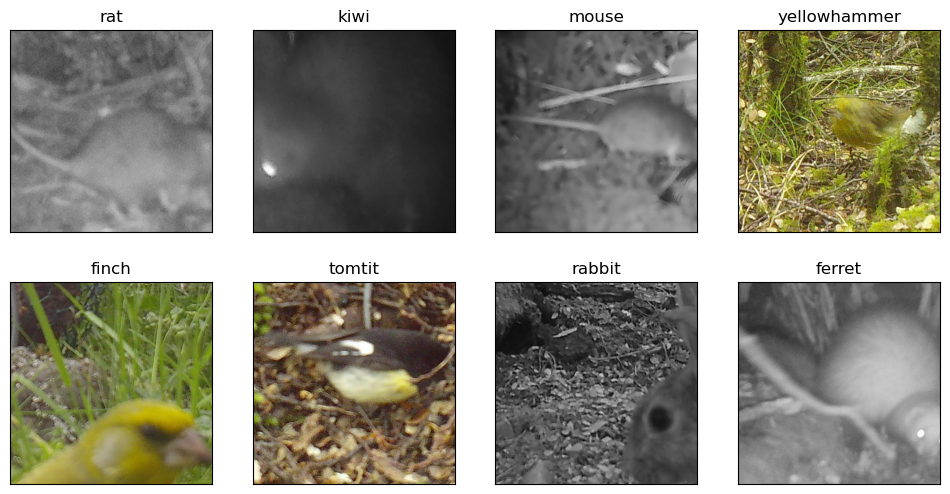

In [13]:
images = show_batch(test_loader, targets_dict, batch_size=8)

## Examine the training performance
Taking a look at some of the test images, but with the data augmentation used for training, to check the images are still recognisable

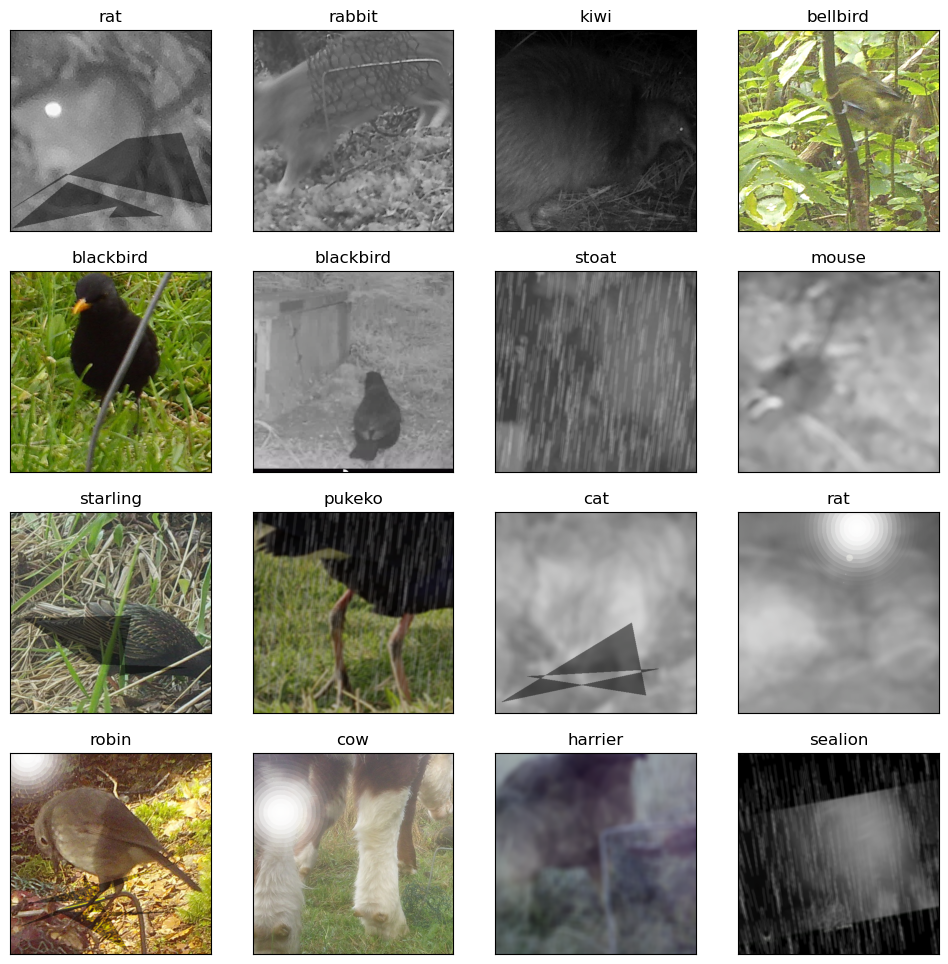

In [14]:
images = show_batch(train_loader, targets_dict, batch_size=16)

Look at logged training metrics logged during the training.

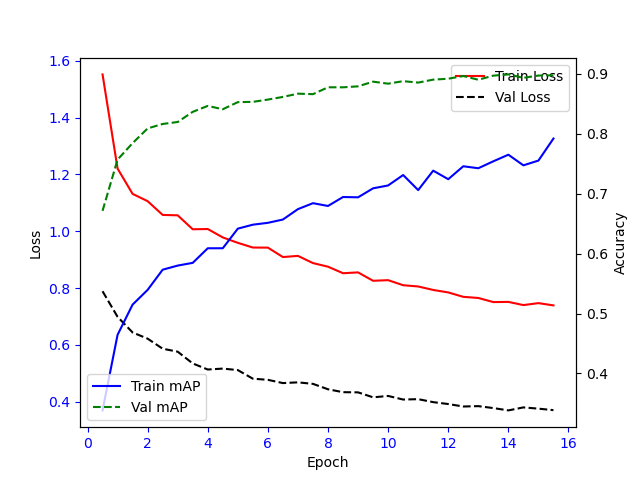

In [15]:
display(Image(str(train_metrics_pth)))

Now looking at the accuracy using macro Average Precision Score (mAP) for the predictions from the last training batch by class, along with their frequencies.  These numbers are expected to be quite low, as the effect of [image mixup](https://paperswithcode.com/method/mixup) was not accounted for in this calculation.  An image that was 30% Pig overlayed 70% Elephant is still scored as 100% Elephant.

In [16]:
train_pred = pd.read_pickle(pickle_paths['train_pred_df'])
train_true = pd.read_pickle(pickle_paths['train_target_df'])
if (train_pred.shape[0] == train_true.shape[0]) and (train_pred.shape[0] >=20):
    _, _ = plot_map_by_class(train_true, train_pred, min_samples=5)
else: print(f'There were only {train_pred.shape[0]} rows in the predictions dataframe, too few for mAP scores')

From counting loop: Removing 10 species, 20.0 instances: [('fluttering_shearwater', 1.0), ('grey_faced_petrol', 0.0), ('kaka', 4.0), ('kingfisher', 3.0), ('mohua', 4.0), ('nz_falcon', 2.0), ('spotted_dove', 2.0), ('stilt', 4.0), ('swallow', 0.0), ('whitehead', 0.0)], 
Removing 10 classes as they have less than 5 samples
Also removing 20 image instances, as they were from those classes


And doing the same for the final validation batch.  This has no augmentation, but the results should not be considered fully independent, as the images are too correlated to each other, and also we are making decisions (such as when to stop training) based on this data.

In [17]:
val_pred = pd.read_pickle(pickle_paths['val_pred_df'])
val_true = pd.read_pickle(pickle_paths['val_target_df'])
if (val_pred.shape[0] == val_true.shape[0]) and (val_pred.shape[0] >=20):
    _, _ = plot_map_by_class(val_true, val_pred)
else:
    print(f'There were only {val_pred.shape[0]} rows in the predictions dataframe, too few for mAP scores') 
    

From counting loop: Removing 11 species, 8.0 instances: [('fluttering_shearwater', 0.0), ('grey_faced_petrol', 0.0), ('kaka', 0.0), ('kingfisher', 1.0), ('mohua', 0.0), ('nz_falcon', 1.0), ('spotted_dove', 0.0), ('stilt', 2.0), ('swallow', 0.0), ('whitehead', 0.0), ('wrybill', 4.0)], 
Removing 11 classes as they have less than 5 samples
Also removing 8 image instances, as they were from those classes


## Load the model and check the model

In [18]:
print(f'Allocated GPU memory at this moment {torch.cuda.memory_allocated()} Bytes')

Allocated GPU memory at this moment 0 Bytes


In [19]:
model_state_dict = torch.load(weights_pth)
model = CustomModel(targets_list, cfg.MODEL_NAME, cfg.HEAD_NAME)
model.load_state_dict(model_state_dict)
model.eval();

There are 1280 input features to the classifier head 80 outputs


Show predictions from one batch

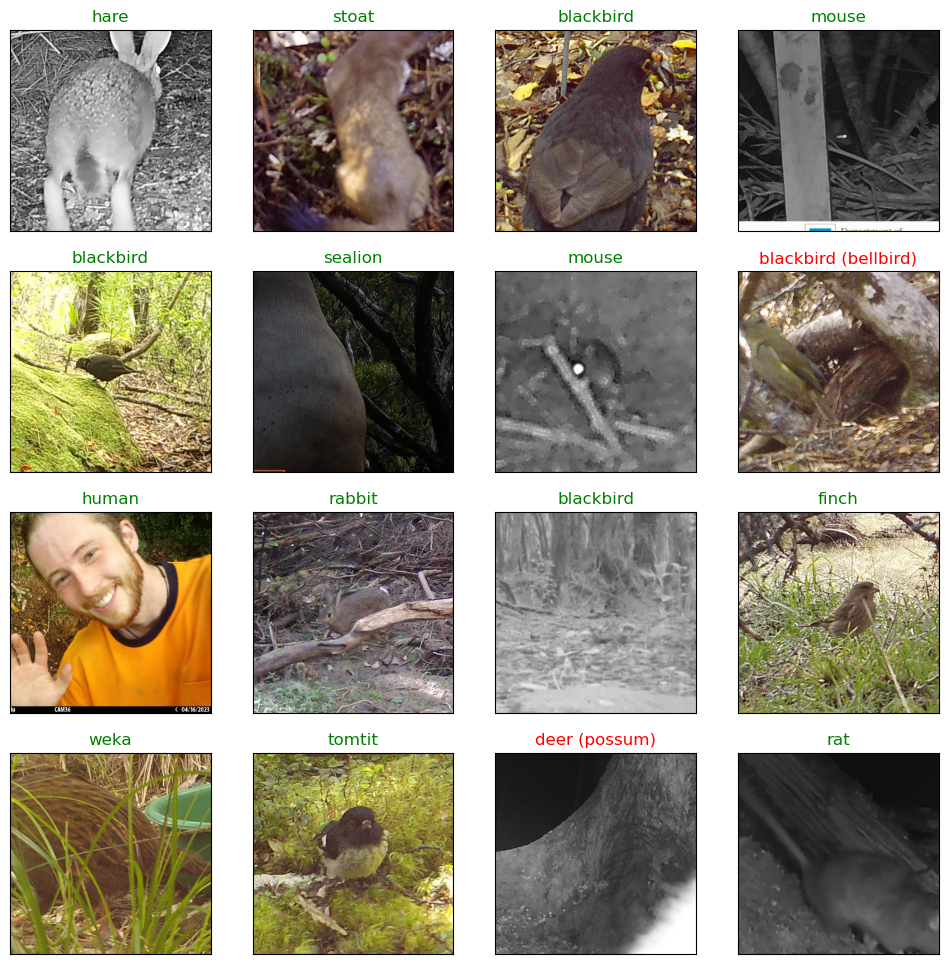

In [20]:
model.to(device)
targets, probs, images = predict_batch(test_loader, model, device)
show_predictions(targets, probs, images, targets_dict)

Run the model over the whole test set

In [21]:
all_targets, all_preds = infer_dataset(test_loader, model, targets_list, device)

if gpu:
    del model
    gc.collect()
    torch.cuda.empty_cache()
cuda_data = torch.cuda.memory_allocated()
print(f'There is {cuda_data} Bytes allocated in the GPU memory after infernce in the evaluation script')

  0%|          | 0/19583 [00:00<?, ?it/s]

Processed 19583 samples in 642.07 seconds
That is a mean of 30.50 images per second
There is 8519680 Bytes allocated in the GPU memory after infernce in the evaluation script


In [22]:
all_targets.head(3)

banded_dotterel  \
C:\Users\User\OneDrive - Department of Conserva...              0.0   
C:\Users\User\OneDrive - Department of Conserva...              0.0   
C:\Users\User\OneDrive - Department of Conserva...              0.0   

                                                    banded_rail  bellbird  \
C:\Users\User\OneDrive - Department of Conserva...          0.0       0.0   
C:\Users\User\OneDrive - Department of Conserva...          0.0       0.0   
C:\Users\User\OneDrive - Department of Conserva...          0.0       0.0   

                                                    black_backed_gull  \
C:\Users\User\OneDrive - Department of Conserva...                0.0   
C:\Users\User\OneDrive - Department of Conserva...                0.0   
C:\Users\User\OneDrive - Department of Conserva...                0.0   

                                                    black_billed_gull  \
C:\Users\User\OneDrive - Department of Conserva...                0.0   
C:\Users\User\OneDrive - Department of Conserva...                0.0   
C:\Users\User\OneDrive - Department of Conserva...                0.0   

                                                    black_fronted_tern  \
C:\Users\User\OneDrive - Department of Conserva...                 0.0   
C:\Users\User\OneDrive - Department of Conserva...                 0.0   
C:\Users\User\OneDrive - Department of Conserva...                 0.0   

                                                    blackbird  canada_goose  \
C:\Users\User\OneDrive - Department of Conserva...        0.0           0.0   
C:\Users\User\OneDrive - Department of Conserva...        0.0           0.0   
C:\Users\User\OneDrive - Department of Conserva...        0.0           0.0   

                                                    cat  chamois  ...  tomtit  \
C:\Users\User\OneDrive - Department of Conserva...  0.0      0.0  ...     0.0   
C:\Users\User\OneDrive - Department of Conserva...  0.0      0.0  ...     0.0   
C:\Users\User\OneDrive - Department of Conserva...  0.0      0.0  ...     0.0   

                                                    tui  wallaby  weasel  \
C:\Users\User\OneDrive - Department of Conserva...  0.0      0.0     0.0   
C:\Users\User\OneDrive - Department of Conserva...  0.0      0.0     0.0   
C:\Users\User\OneDrive - Department of Conserva...  0.0      0.0     0.0   

                                                    weka  white_faced_heron  \
C:\Users\User\OneDrive - Department of Conserva...   0.0                0.0   
C:\Users\User\OneDrive - Department of Conserva...   0.0                0.0   
C:\Users\User\OneDrive - Department of Conserva...   0.0                0.0   

                                                    whitehead  wrybill  \
C:\Users\User\OneDrive - Department of Conserva...        0.0      0.0   
C:\Users\User\OneDrive - Department of Conserva...        0.0      0.0   
C:\Users\User\OneDrive - Department of Conserva...        0.0      0.0   

                                                    yellow_eyed_penguin  \
C:\Users\User\OneDrive - Department of Conserva...                  0.0   
C:\Users\User\OneDrive - Department of Conserva...                  0.0   
C:\Users\User\OneDrive - Department of Conserva...                  0.0   

                                                    yellowhammer  
C:\Users\User\OneDrive - Department of Conserva...           0.0  
C:\Users\User\OneDrive - Department of Conserva...           0.0  
C:\Users\User\OneDrive - Department of Conserva...           0.0  

[3 rows x 80 columns]

In [23]:
print(f'Total number of classes used in this model: {len(all_targets.columns)}')
print(f'Number of duplicate rows in the targets: {all_targets.index.duplicated().sum()}')
print(f'Number of duplicate rows in the predictions: {all_preds.index.duplicated().sum()}')


Total number of classes used in this model: 80
Number of duplicate rows in the targets: 0
Number of duplicate rows in the predictions: 0


Calculate whole-dataset metrics

In [24]:
def get_metrics(targets, predictions, min_freq=5):
    targets, predictions = remove_rare_classes(targets, predictions, min_freq)
    balanced_accuracy = get_ba_score(targets, predictions)
    overall_accuracy = get_accuracy_score(targets, predictions)
    map_scores = get_map_score(targets, predictions)['mean']  #for some reason, this can only run once
    f1_score = get_f1_score(targets, predictions)

    print(Colour.S + f'Overall accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{overall_accuracy:.3f}')
    print(Colour.S + f'Balanced accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{balanced_accuracy:.3f}')
    print(Colour.S + f'macro Average Precision Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{map_scores:.3f}')
    print(Colour.S + f'macro F1 Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{f1_score:.3f}')
    return overall_accuracy, balanced_accuracy, map_scores, f1_score

overall_acc_1, balanced_acc_1, map_1, f1_1 = get_metrics(all_targets, all_preds)

From counting loop: Removing 15 species, 14.0 instances: [('black_billed_gull', 4.0), ('fluttering_shearwater', 0.0), ('grey_faced_petrol', 0.0), ('grey_warbler', 2.0), ('kaka', 0.0), ('kingfisher', 0.0), ('mohua', 0.0), ('nz_falcon', 0.0), ('rosella', 2.0), ('spotted_dove', 0.0), ('stilt', 1.0), ('swallow', 1.0), ('swan', 1.0), ('whitehead', 0.0), ('wrybill', 3.0)], 
Removing 15 classes as they have less than 5 samples
Also removing 14 image instances, as they were from those classes
Overall accuracy score for classes with more than 5 samples is: 0.848
Balanced accuracy score for classes with more than 5 samples is: 0.834
macro Average Precision Score for classes with more than 5 samples is: 0.912
macro F1 Score for classes with more than 5 samples is: 0.850


Concatenate the predicted probabilties, target class into a single dataframe

In [25]:
table = make_output_table(all_targets, all_preds, targets_dict)
pd.set_option('display.width', 90) 
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_colwidth', 30)
table.to_parquet(test_preds_pth)
table.iloc[:, :10].head(3)

Target Prediction  Probability Second Pred  Second Prob  \
C:\Users\User\OneDrive - De...   stoat       deer       0.4436       stoat       0.4403   
C:\Users\User\OneDrive - De...   sheep     possum       0.1808        kiwi       0.1598   
C:\Users\User\OneDrive - De...  possum     possum       0.9571         cat       0.0211   

                               Third Pred  Third Prob  banded_dotterel  banded_rail  \
C:\Users\User\OneDrive - De...        pig      0.0402              0.0          0.0   
C:\Users\User\OneDrive - De...        kea      0.1483              0.0          0.0   
C:\Users\User\OneDrive - De...        rat      0.0082              0.0          0.0   

                                bellbird  
C:\Users\User\OneDrive - De...       0.0  
C:\Users\User\OneDrive - De...       0.0  
C:\Users\User\OneDrive - De...       0.0

Plot the resulting mean average precision by class

In [26]:
names, scores = plot_map_by_class(all_targets, all_preds, min_samples=5)
test_accuracy_df = pd.DataFrame({'Name': names, 'macroAveragePrecision': scores})
test_accuracy_df.to_csv(class_acc_pth, index=False)

From counting loop: Removing 15 species, 14.0 instances: [('black_billed_gull', 4.0), ('fluttering_shearwater', 0.0), ('grey_faced_petrol', 0.0), ('grey_warbler', 2.0), ('kaka', 0.0), ('kingfisher', 0.0), ('mohua', 0.0), ('nz_falcon', 0.0), ('rosella', 2.0), ('spotted_dove', 0.0), ('stilt', 1.0), ('swallow', 1.0), ('swan', 1.0), ('whitehead', 0.0), ('wrybill', 3.0)], 
Removing 15 classes as they have less than 5 samples
Also removing 14 image instances, as they were from those classes


Plot a confusion matrix

From counting loop: Removing 8 species, 0.0 instances: [('fluttering_shearwater', 0.0), ('grey_faced_petrol', 0.0), ('kaka', 0.0), ('kingfisher', 0.0), ('mohua', 0.0), ('nz_falcon', 0.0), ('spotted_dove', 0.0), ('whitehead', 0.0)], 
Removing 8 classes as they have less than 1 samples
Also removing 0 image instances, as they were from those classes


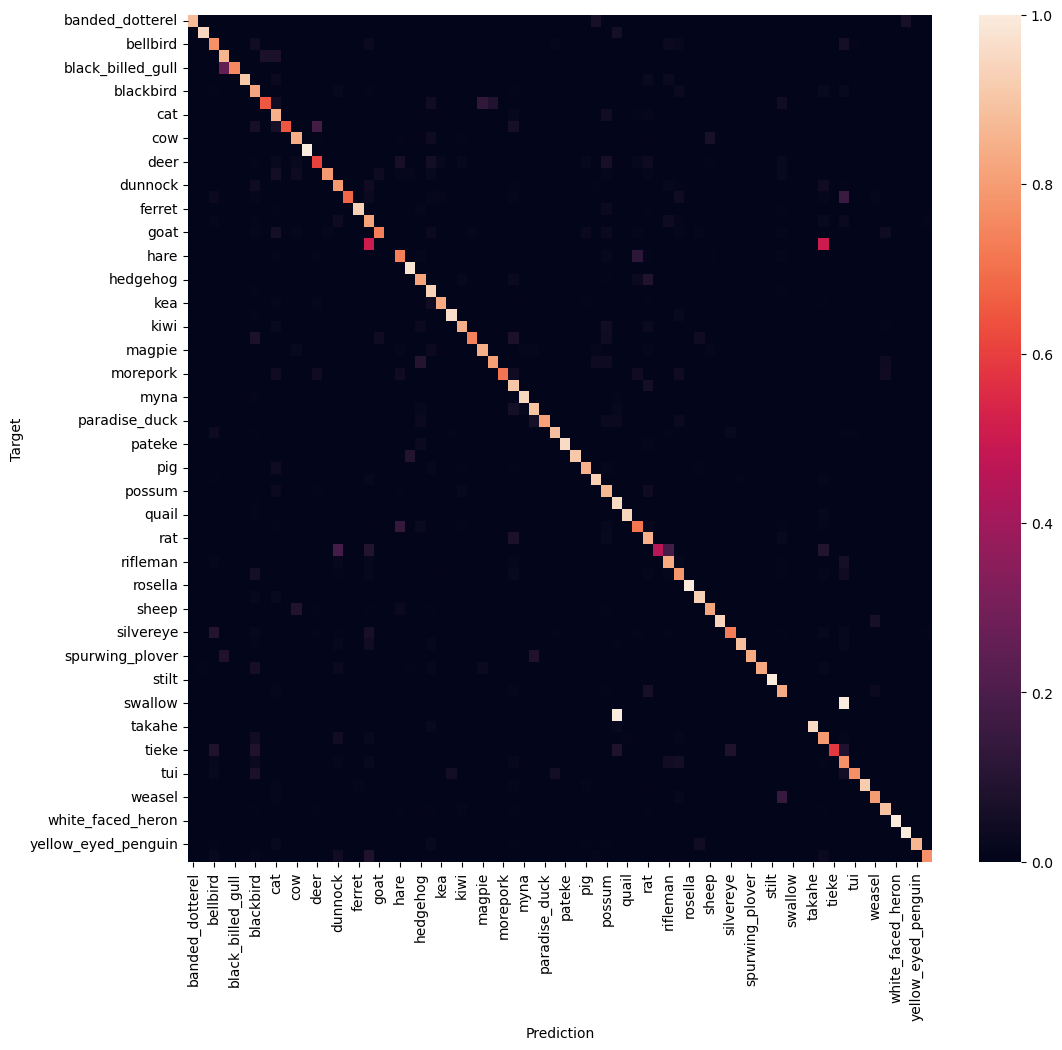

In [27]:
build_cf_matrix(all_targets, all_preds)

## Evaluating on an independent test set
The randomly selected test images evaluated earlier could potentially be correlated to the training data as they come from the same locations and so the background is the same.  This is a known challenge with trail cam image classification.  To get a more reliable performance assessment we have held some specific camera locations out of the training routine entirely.  The following test locations were used for this:

In [28]:
cfg.INDEPENDENT_TEST_ONLY

"['N01', 'BWS', 'EBF', 'EM1', 'ES1']"

The next cell runs the inference script, exactly as it would do in real use.  Cropping from large images with MegaDetector first.  The parquet file produced will be exactly the shape and classes defined in training and in the inference notebook (which must match in their default settings if not running from a common settings file).

However this script knows nothing about the class file names used for the test set, so those names will need to be cleaned and re-named as per the same settings to be useful for evaluation, prior to the one-hot encoding step which puts them into a dataframe.

In [29]:
importlib.reload(Inference)
inferred_df, speed = Inference.main(settings_pth, external_image_dir=independent_image_dir)
inferred_df.iloc[:,16].head()
cuda_data = torch.cuda.memory_allocated()
print(f'There is {cuda_data} Bytes allocated data left in the GPU memory after inference on the independent dataset')

Exp_26/Runs/Run_01/Models/Run_01_weights/Run_01_best_weights.pt is a valid PyTorch weights file for the Classifier
User/OneDrive - Department of Conservation/Desktop/Predator_AI_Project/Models/md_v5a.0.0.pt is the weights file for the MegaDetector
Checking for suitable media files (.jpg, .jpeg, .mp4, .avi & .mov)


45328it [00:02, 15257.87it/s]


44918 media files found for classification
Searching for video files
Extracting 0 video files to jpg images
Total video processing time was 0.0
json files found [WindowsPath('c:/Users/User/OneDrive - Department of Conservation/Desktop/Predator_AI_Project/Data/Independent_Images/mdPredictions.json')]
The root path of the image folder is c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Independent_Images
The dataframe length after processing c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Independent_Images\mdPredictions.json: 10987
['blackbird' 'unknown' 'dog' 'dunnock' 'fantail' 'hare' 'kereru'
 'morepork' 'mouse' 'paradise_duck' 'robin' 'silvereye' 'thrush' 'tomtit'
 'cat' 'cow' 'deer' 'ferret' 'harrier' 'hedgehog' 'human' 'magpie' 'pipit'
 'possum' 'rabbit' 'stoat' 'weasel' 'yellowhammer' 'bellbird' 'goat' 'kea'
 'kiwi' 'pig' 'rat' 'rifleman' 'weka' 'banded_dotterel' 'tui']
Length of the labels dataframe: 10987


100%|██████████| 95/95 [00:00<00:00, 117.29it/s]


The dataframe saved to CSV
                                          Date_Time  Encounter  Max_Prob
Image_File_Paths                                                        
C:\Users\User\OneDrive - De...  16/08/2020 16:50:58  blackbird     0.982
C:\Users\User\OneDrive - De...  16/08/2020 16:50:59  blackbird     0.982
C:\Users\User\OneDrive - De...  16/08/2020 16:50:59  blackbird     0.982
C:\Users\User\OneDrive - De...  19/08/2020 08:36:29  blackbird     0.890
C:\Users\User\OneDrive - De...  19/08/2020 08:36:29  blackbird     0.890
Process Complete
The predictions csv file was saved to: c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Independent_Images\Exp_26_Run_01_predictions.csv
There is 8519680 Bytes allocated data left in the GPU memory after inference on the independent dataset


In [30]:
inferred_df.to_parquet(out_parquet_path)
print(f'The predictions parquet file was saved to {out_parquet_path}')

The predictions parquet file was saved to c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Experiments\Exp_26\Runs\Run_01\Results\Run_01_infer_predictions.parquet


In [31]:
inferred_df.iloc[:,:17].head(1)

Date_Time Encounter_Start  Encounter  \
Image_File_Paths                                                                 
C:\Users\User\OneDrive - De...  16/08/2020 16:50:58        16:50:58  blackbird   

                                Max_Prob    Targets Prediction  Probability  ...  \
Image_File_Paths                                                             ...   
C:\Users\User\OneDrive - De...     0.982  blackbird  blackbird        0.797  ...   

                               Third_Prob                           Crop  x_min  y_min  \
Image_File_Paths                                                                         
C:\Users\User\OneDrive - De...       0.04  [0.8745, 0.2361, 0.9996, 0...  0.875  0.287   

                                Width  Height  Confidence  
Image_File_Paths                                           
C:\Users\User\OneDrive - De...  0.125    0.12       0.868  

[1 rows x 17 columns]

In [32]:
inferred_df.iloc[:,17:].head(1)

banded_dotterel  banded_rail  bellbird  \
Image_File_Paths                                                         
C:\Users\User\OneDrive - De...              0.0          0.0     0.002   

                                black_backed_gull  black_billed_gull  \
Image_File_Paths                                                       
C:\Users\User\OneDrive - De...                0.0                0.0   

                                black_fronted_tern  blackbird  ...  weka  \
Image_File_Paths                                               ...         
C:\Users\User\OneDrive - De...                 0.0      0.797  ...   0.0   

                                white_faced_heron  whitehead  wrybill  \
Image_File_Paths                                                        
C:\Users\User\OneDrive - De...                0.0        0.0      0.0   

                                yellow_eyed_penguin  yellowhammer  \
Image_File_Paths                                                    
C:\Users\User\OneDrive - De...                  0.0           0.0   

                                                    File_Path  
Image_File_Paths                                               
C:\Users\User\OneDrive - De...  C:\Users\User\OneDrive - D...  

[1 rows x 81 columns]

In [33]:
print(f"There are {inferred_df['Targets'].nunique()} unique targets based on folder names")
print(f'There are {inferred_df.iloc[:,17:].shape[1]} unique targets in the model predictions')
print(f'There are {inferred_df.shape[0]} rows in the model output file')
unique_targets = inferred_df['Targets'].unique()
targets_no_column = set(unique_targets) - set(inferred_df.columns)
print(f'These are the targets that do not have a matching prediction class: {targets_no_column}')
for mystery_targ in targets_no_column:
    no_col_count = (inferred_df['Targets'] == mystery_targ).sum()
    print(f"There are {no_col_count} rows with the unmatched target of: {mystery_targ}")


There are 38 unique targets based on folder names
There are 81 unique targets in the model predictions
There are 10987 rows in the model output file
These are the targets that do not have a matching prediction class: {'unknown'}
There are 56 rows with the unmatched target of: unknown


In [34]:
def clean_independent_dataset(pred_df, cfg):
    original_shape = pred_df.shape
    to_drop = cfg.CLASSES_TO_IGNORE + cfg.CLASSES_TO_EXCLUDE
    pred_df = pred_df[~pred_df['Targets'].isin(to_drop)]
    # Get a dict to handle all name changes by merger
    flattened_list = [(key, value) for key, values in cfg.CLASS_JOINS.items() for value in values]
    inv_merge = {val:key for (key, val) in flattened_list}
    # Add the merger dict, to the name change dict, then do the name change
    rename_dict = cfg.CLASS_NAME_CHANGE.update(inv_merge)
    pred_df['Targets'] = pred_df['Targets'].replace(to_replace=rename_dict, )  #value=None
    # Remove any remaining classes that still don't correspond to a model column
    unique_targets = pred_df['Targets'].unique()
    targets_no_column = set(unique_targets) - set(inferred_df.columns)
    print(f'These are the targets that do not have a matching prediction class: {targets_no_column}')
    mystery_total = 0
    for mystery_targ in targets_no_column:
        no_col_count = (inferred_df['Targets'] == mystery_targ).sum()
        mystery_total += no_col_count
        print(f"There are {no_col_count} rows with the unmatched target of: {mystery_targ}")
    if mystery_targ:
        print(f'{mystery_total} rows with targets correstponding to missing classes have been removed')
    pred_df = pred_df[~pred_df['Targets'].isin(targets_no_column)]
    
    print(f'The original shape was {original_shape}, and the final shape was {pred_df.shape}')
    print('The original shape should match the number of files, the final shape should match the number of \n'
          f'classes defined in training plus the 13 other metadata columns: {len(all_targets.columns) + 13}')
    return pred_df

cleaned_inf_df = clean_independent_dataset(inferred_df, cfg)

These are the targets that do not have a matching prediction class: {'unknown'}
There are 56 rows with the unmatched target of: unknown
56 rows with targets correstponding to missing classes have been removed
The original shape was (10987, 98), and the final shape was (10931, 98)
The original shape should match the number of files, the final shape should match the number of 
classes defined in training plus the 13 other metadata columns: 93


C:\Users\User\AppData\Local\Temp\ipykernel_26468\1083373210.py:10: FutureWarning:

Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.



In [35]:
print(f"There are {cleaned_inf_df.Targets.nunique()} unique classes in the independent test set, from {cleaned_inf_df.shape[0]} images")

There are 37 unique classes in the independent test set, from 10931 images


Purple = The classifier crop  
Blue = The MegaDetector Bounding box

In [36]:
cleaned_inf_df.head(3)

Date_Time Encounter_Start  Encounter  \
Image_File_Paths                                                                 
C:\Users\User\OneDrive - De...  16/08/2020 16:50:58        16:50:58  blackbird   
C:\Users\User\OneDrive - De...  16/08/2020 16:50:59        16:50:58  blackbird   
C:\Users\User\OneDrive - De...  16/08/2020 16:50:59        16:50:58  blackbird   

                                Max_Prob    Targets Prediction  Probability  ... weka  \
Image_File_Paths                                                             ...        
C:\Users\User\OneDrive - De...     0.982  blackbird  blackbird        0.797  ...  0.0   
C:\Users\User\OneDrive - De...     0.982  blackbird  blackbird        0.959  ...  0.0   
C:\Users\User\OneDrive - De...     0.982  blackbird  blackbird        0.982  ...  0.0   

                                white_faced_heron whitehead  wrybill  \
Image_File_Paths                                                       
C:\Users\User\OneDrive - De...                0.0       0.0      0.0   
C:\Users\User\OneDrive - De...                0.0       0.0      0.0   
C:\Users\User\OneDrive - De...                0.0       0.0      0.0   

                               yellow_eyed_penguin  yellowhammer  \
Image_File_Paths                                                   
C:\Users\User\OneDrive - De...                 0.0           0.0   
C:\Users\User\OneDrive - De...                 0.0           0.0   
C:\Users\User\OneDrive - De...                 0.0           0.0   

                                                    File_Path  
Image_File_Paths                                               
C:\Users\User\OneDrive - De...  C:\Users\User\OneDrive - D...  
C:\Users\User\OneDrive - De...  C:\Users\User\OneDrive - D...  
C:\Users\User\OneDrive - De...  C:\Users\User\OneDrive - D...  

[3 rows x 98 columns]

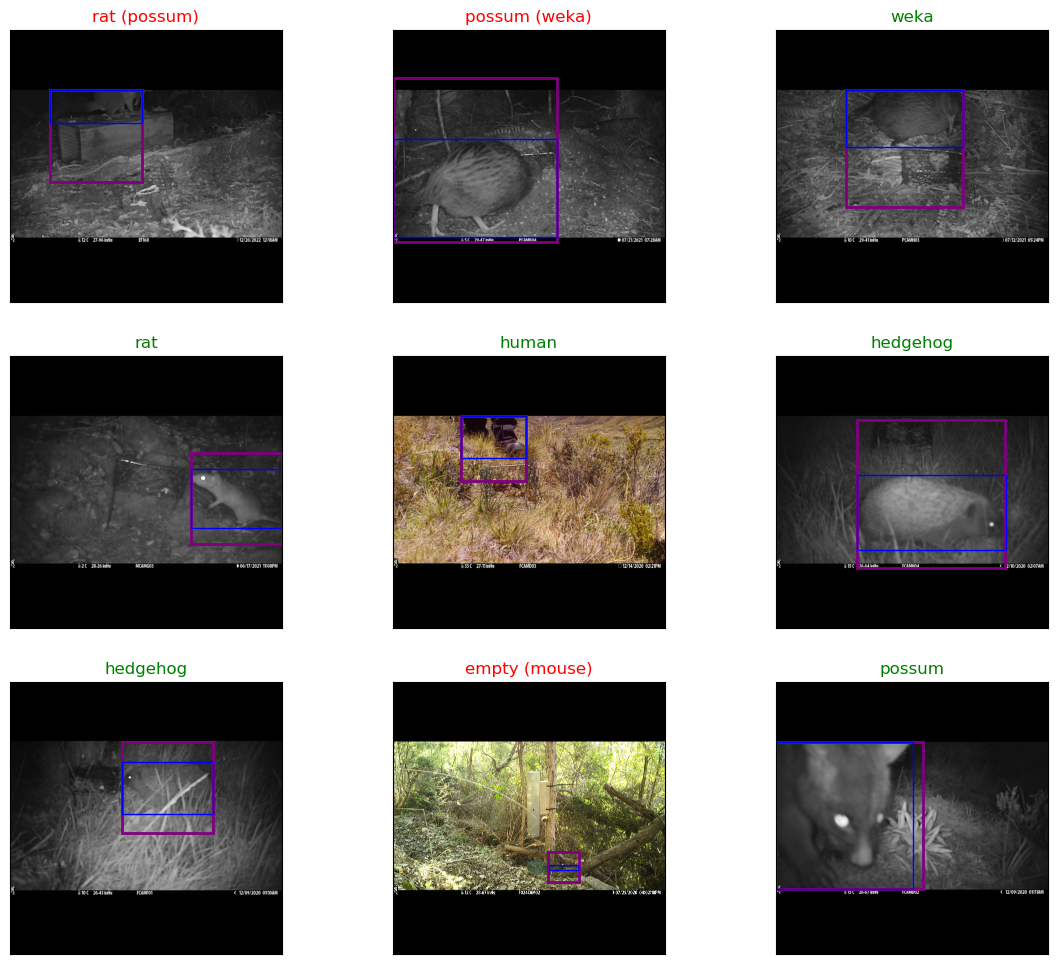

In [37]:
show_inferred_imgs(cleaned_inf_df, num_ims=9)

In [38]:
keepers = balance_data(cleaned_inf_df[['Targets']], str(independent_image_dir), 100, 400 )
cleaned_inf_df = cleaned_inf_df.loc[keepers]
print(f'Now there are {len(cleaned_inf_df)} rows in the dataframe')

Now there are 2053 rows in the dataframe


In [39]:
inf_preds_df = cleaned_inf_df.iloc[:,17:]
inf_preds_df.head(3)
inf_preds_df.to_csv(balanced_preds_path)

Ideally this test dataset would be a perfect representation of the class distribution that the future model will be used for, from a wide variety of locations, with no overlap with the test locations.  But unfortunately we don't know the final distribution in advance.  Also we don't want to waste the rarer classes on this, which in some cases have less than 50 total images for training.  

However for decisions about improvement of the model, a reasonable compromise is to select a modest and somewhat similar number of each of the important classes.  To this end, I'm going to randomly subset the data to a maximum of 400 class instances, with a maximum of 200 from any one dataset-location.  Also remove any classes with less than 40 images, so there is only a factor of 10 between the most and least common classes.

In [40]:
min_samples=40
inf_targs_df = pd.get_dummies(cleaned_inf_df['Targets']).astype(int)
inf_targs_df.index = inf_preds_df.index
all_classes = list(inf_preds_df.columns)
missing_classes = list(set(all_classes).difference(set(cleaned_inf_df.Targets.unique())))
inf_targs_df[missing_classes] = 0
inf_targs_df = inf_targs_df[all_classes]
rows_with_no_target = inf_targs_df.index[inf_targs_df.sum(axis=1) == 0] 
print(Colour.S + 'Rows with no target: ' + Colour.E, len(rows_with_no_target))
targets, predictions = remove_rare_classes(inf_targs_df, inf_preds_df, 40)
print(f'The shape of the final targets, predictions dataframe is {targets.shape}, {predictions.shape}')
overall_acc_2, balanced_acc_2, map_2, f1_2 = get_metrics(targets, predictions, min_samples)

Rows with no target:  0
From counting loop: Removing 61 species, 278 instances: [('banded_dotterel', 1), ('banded_rail', 0), ('bellbird', 7), ('black_backed_gull', 0), ('black_billed_gull', 0), ('black_fronted_tern', 0), ('canada_goose', 0), ('chamois', 0), ('cow', 7), ('crake', 0), ('dog', 9), ('dunnock', 24), ('fantail', 20), ('finch', 0), ('fluttering_shearwater', 0), ('grey_faced_petrol', 0), ('grey_warbler', 0), ('kaka', 0), ('kea', 3), ('kingfisher', 0), ('little_blue_penguin', 0), ('magpie', 9), ('mallard', 0), ('mohua', 0), ('morepork', 6), ('myna', 0), ('nz_falcon', 0), ('oystercatcher', 0), ('paradise_duck', 39), ('parakeet', 0), ('pateke', 0), ('pheasant', 0), ('pig', 34), ('pipit', 35), ('pukeko', 0), ('quail', 0), ('rabbit', 35), ('redpoll', 0), ('rifleman', 12), ('rosella', 0), ('sealion', 0), ('sheep', 0), ('shore_plover', 0), ('sparrow', 0), ('spotted_dove', 0), ('spurwing_plover', 0), ('starling', 0), ('stilt', 0), ('swallow', 0), ('swan', 0), ('takahe', 0), ('tieke', 

In [41]:
names, scores = plot_map_by_class(targets, predictions, min_samples=5, height=400)

The most useful figure for the end user is likely to be the balanced accuracy, on the Encounter column.

In [42]:
def collate_encounters(df, time_window=30, possibles=[], all_classes=[]):
    """Looks at the previous image, and if it was within 30 seconds adds it to the same encounter
    Also removes all columns from classes in the impossibles list"""
    df=df.copy()
    filter = list(set(all_classes)-set(possibles))
    df= df.drop(columns=filter)
    df = df[df['Targets'].isin(possibles)]
    df['dt_object'] = pd.to_datetime(df['Date_Time'], dayfirst=True, format="%d/%m/%Y %H:%M:%S")
    df.sort_values(by='dt_object', inplace=True, ascending=True)
    df = df.reset_index()
    df['time_difference'] = df['dt_object'].diff()
    df['Encounter_Start'] = df['dt_object'] #Set the default
    df.loc[df['time_difference'] <= pd.Timedelta(seconds=time_window), 'Encounter_Start'] = df['Encounter_Start'].shift(1)
    max_prob_rows = df.loc[df.groupby('Encounter_Start')['Probability'].idxmax()]
    df['Encounter'] = df['Encounter_Start'].map(max_prob_rows.set_index('Encounter_Start')['Prediction'])
    return df


def get_encounter_metrics(df, min_samples=1):
    """Takes just one column of targets, one of predictions, so that it can be used with the encounter column"""
    df = df.copy()
    class_counts = df['Targets'].value_counts()
    mask = df['Targets'].isin(class_counts[class_counts > min_samples].index)
    df = df[mask]
    target_list = df['Targets'].to_list()
    encounter_list = df['Encounter'].to_list()
    prediction_list = df['Prediction'].to_list()
    warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")
    balanced_accuracy_pred = round(balanced_accuracy_score(target_list, prediction_list), 3)  
    balanced_accuracy_enc = round( balanced_accuracy_score(target_list, encounter_list), 3)
    balanced_f1_pred = round(skm.f1_score(target_list, prediction_list, average='macro', zero_division=np.nan), 3)  #[None, 'micro', 'macro', 'weighted']
    balanced_f1_enc = round(skm.f1_score(target_list, encounter_list, average='macro', zero_division=np.nan), 3)  #[None, 'micro', 'macro', 'weighted']
    warnings.resetwarnings()
    return balanced_accuracy_pred, balanced_accuracy_enc,  balanced_f1_pred, balanced_f1_enc

In [43]:
encounter_df = collate_encounters(cleaned_inf_df, possibles=all_classes, all_classes=all_classes)
balanced_acc_img, balanced_acc_enc,  balanced_f1_img, balanced_f1_enc = get_encounter_metrics(encounter_df, min_samples=40)

print('Metrics for all classes in the independent set, by image')
print(Colour.S + 'Balanced Accuracy Score By Image:' + Colour.E, balanced_acc_img)
print(Colour.S + 'Balanced F1 Score by Image:' + Colour.E, balanced_f1_img, '\n')

print('Metrics for all classes in the independent set, by encounter')
print(Colour.S + 'Balanced Accuracy Score By Encounter:' + Colour.E, balanced_acc_enc)
print(Colour.S + 'Balanced F1 Score by Encounter:' + Colour.E, balanced_f1_enc)

Metrics for all classes in the independent set, by image
Balanced Accuracy Score By Image: 0.66
Balanced F1 Score by Image: 0.708 

Metrics for all classes in the independent set, by encounter
Balanced Accuracy Score By Encounter: 0.697
Balanced F1 Score by Encounter: 0.741


These values don't quite match the previous calculations, because the rarer classes were removed from the dataframe, prior to calculation of the maximum probability for each score.
The key point here is we get a boost of around 4% in useful perfomance by using encounter prediction instead of image prediction.

In [44]:
rodents= ['rat','mouse']
predators = ['rat', 'possum', 'cat', 'stoat', 'weasel']
encounter_df = collate_encounters(cleaned_inf_df, possibles=predators, all_classes=all_classes)
_, balanced_acc_enc,  _, balanced_f1_enc = get_encounter_metrics(encounter_df, min_samples=40)

print('Encounter Metrics just for rats, possum, cat, stoat, weasel')
print(Colour.S + 'Balanced Accuracy Score By Encounter:' + Colour.E, balanced_acc_enc)
print(Colour.S + 'Balanced F1 Score by Encounter:' + Colour.E, balanced_f1_enc)

Encounter Metrics just for rats, possum, cat, stoat, weasel
Balanced Accuracy Score By Encounter: 0.682
Balanced F1 Score by Encounter: 0.751


In [45]:
important_animals = cfg.TO_MONITOR 
print(f'Monitored animals: {important_animals}')
important_animal_idxs = {item: i if item in important_animals else 0 for i, item in enumerate(names)}

important_animal_scores = []
for animal in important_animals:
    idx = important_animal_idxs[animal] if animal in names else None
    score = scores[idx] if animal in set(names).intersection(important_animals) else 0
    important_animal_scores.append(score)  
for idx, animal in enumerate(important_animals): 
    print(f'{animal}: {important_animal_scores[idx]:.3f}')

Monitored animals: ['cat', 'mouse', 'possum', 'rat', 'stoat']
cat: 0.747
mouse: 0.589
possum: 0.785
rat: 0.787
stoat: 0.870


Confusion matrix from inference on independent dataset


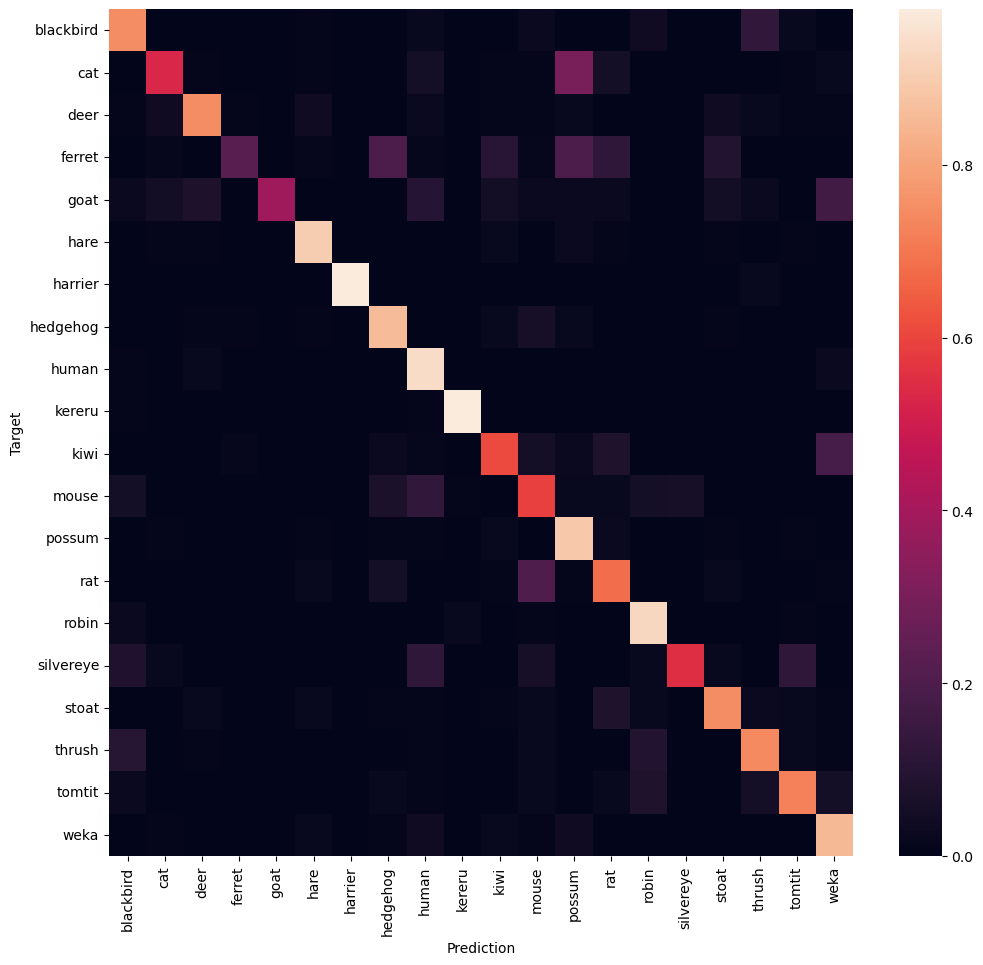

In [46]:
print(Colour.S + 'Confusion matrix from inference on independent dataset' + Colour.E)
build_cf_matrix(targets, predictions)

Log the performance metrics to a tracking file to monitor changes to the model relative to previous training runs.

In [47]:
column_headers = ['Experiment', 'Run_ID', 'Date-Hour', 'Num_Test_Species', 'Num_Test_Images', 
                  'Test_Overall_Accuracy', 'Test_Balanced_Accuracy', 'Test_mAP', 'Test_F1', 
                  'Num_Ind_Location_Species', 'Num_Ind_Images', 'Ind_Overall_Accuracy', 'Ind_Balanced_Accuracy',
                  'Ind_mAP', 'Ind_F1'] + important_animals + ['Images_per_sec']
print(column_headers)
if performance_log_pth.exists():
    df = pd.read_csv(performance_log_pth)
else:
    df = pd.DataFrame(columns=column_headers)

['Experiment', 'Run_ID', 'Date-Hour', 'Num_Test_Species', 'Num_Test_Images', 'Test_Overall_Accuracy', 'Test_Balanced_Accuracy', 'Test_mAP', 'Test_F1', 'Num_Ind_Location_Species', 'Num_Ind_Images', 'Ind_Overall_Accuracy', 'Ind_Balanced_Accuracy', 'Ind_mAP', 'Ind_F1', 'cat', 'mouse', 'possum', 'rat', 'stoat', 'Images_per_sec']


In [48]:
metrics_list_1 = [overall_acc_1, balanced_acc_1, map_1, f1_1]
metrics_list_2 = [overall_acc_2, balanced_acc_2, map_2, f1_2]
now = datetime.now().strftime('%y_%m_%d_%H')
num_independent_species = predictions.shape[1]
num_independent_images = predictions.shape[0]
row_list = [cfg.EXPERIMENT_NAME, cfg.RUN_ID, now, num_test_species, num_test_images] + metrics_list_1 + \
            [num_independent_species, num_independent_images] + metrics_list_2 + important_animal_scores + [speed]
new_row_dict = dict(zip(column_headers, row_list))
for key, value in new_row_dict.items():
    if isinstance(value, (int, float)):
        new_row_dict[key] = round(value, 3)
df.loc[len(df)] = new_row_dict
print(Colour.S + 'Metrics from the test dataset' + Colour.E)
df.iloc[-5:,:9]

Metrics from the test dataset


Experiment  Run_ID    Date-Hour  Num_Test_Species  Num_Test_Images  \
38     Exp_26  Run_02  24_01_22_11                23            19583   
39     Exp_26  Run_02  24_01_22_16                23            19583   
40     Exp_31  Run_01  24_01_26_09                78            63903   
41     Exp_26  Run_01  24_05_03_16                72            19583   
42     Exp_26  Run_01  24_05_07_12                72            19583   

    Test_Overall_Accuracy  Test_Balanced_Accuracy  Test_mAP  Test_F1  
38                  0.899                   0.836     0.912    0.850  
39                  0.899                   0.836     0.912    0.850  
40                  0.852                   0.804     0.890    0.845  
41                  0.848                   0.834     0.912    0.850  
42                  0.848                   0.834     0.912    0.850

In [49]:
print(Colour.S + 'Metrics from the independent monitoring dataset' + Colour.E)
df.iloc[-8:,9:]

Metrics from the independent monitoring dataset


Num_Ind_Location_Species  Num_Ind_Images  Ind_Overall_Accuracy  \
35                        13            2594                 0.747   
36                        20            3637                 0.729   
37                        20            3637                 0.728   
38                        13            2594                 0.769   
39                        13            2594                 0.771   
40                        20            3637                 0.732   
41                        20            1775                 0.743   
42                        20            1775                 0.750   

    Ind_Balanced_Accuracy  Ind_mAP  Ind_F1    cat  mouse  possum    rat  stoat  \
35                  0.687    0.806   0.703  0.839  0.491   0.875  0.796  0.838   
36                  0.690    0.796   0.694  0.868  0.493   0.851  0.787  0.860   
37                  0.692    0.802   0.697  0.802  0.554   0.868  0.738  0.862   
38                  0.707    0.819   0.719  0.851  0.625   0.867  0.806  0.871   
39                  0.707    0.823   0.719  0.851  0.622   0.880  0.797  0.865   
40                  0.692    0.792   0.699  0.813  0.558   0.861  0.768  0.872   
41                  0.724    0.842   0.728  0.830  0.595   0.837  0.829  0.882   
42                  0.731    0.837   0.734  0.747  0.589   0.785  0.787  0.870   

    Images_per_sec  
35          18.951  
36          14.530  
37          20.129  
38          18.875  
39          18.715  
40          19.278  
41          22.643  
42          21.730

In [50]:
if not cfg.DEBUG:
    df.to_csv(performance_log_pth, index = False)
    print(Colour.S +'Monitoring file saved to: ' + Colour.E, performance_log_pth)

Monitoring file saved to:  c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Python\Setup\Performance_Monitor.csv


## Performance on Empties
Up until now, all the focus was on the precision of the multi-class classifier on data where we knew there were animals present.  The overall performance, and practical use depends on the models ability to reject empty images.  However at this point we haven't trained a specific empties class, but rather relied mostly on the MegaDetector Confidence score.

This next section evaluates the overall performance, once a folder of known empty images is added to the evaluation dataset.

In [52]:
empties_df, speed = Inference.main(settings_pth, external_image_dir=empty_image_dir)

Exp_26/Runs/Run_01/Models/Run_01_weights/Run_01_best_weights.pt is a valid PyTorch weights file for the Classifier
User/OneDrive - Department of Conservation/Desktop/Predator_AI_Project/Models/md_v5a.0.0.pt is the weights file for the MegaDetector
Checking for suitable media files (.jpg, .jpeg, .mp4, .avi & .mov)


570it [00:00, 26367.05it/s]

561 media files found for classification
Searching for video files
Extracting 0 video files to jpg images
Total video processing time was 0.0


json files found [WindowsPath('c:/Users/User/OneDrive - Department of Conservation/Desktop/Predator_AI_Project/Data/Empty_Images/mdPredictions.json')]
The root path of the image folder is c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Empty_Images
The dataframe length after processing c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Empty_Images\mdPredictions.json: 561
['unknown']
Length of the labels dataframe: 561
                       File_Path  Mega_Class  Confidence   x_min   y_min    Width  \
0  c:\Users\User\OneDrive - D...          -1      -1.000  0.0000  0.0000  1.00000   
1  c:\Users\User\OneDrive - D...           1       0.431  0.4475  0.9328  0.09895   
2  c:\Users\User\OneDrive - D...          -1      -1.000  0.0000  0.0000  1.00000   

   Height  Species Location  Targets  
0  1.0000  unknown  unknown  unknown  
1  0.0359  unknown  unknown  unknown  
2  1.0000  unknown  unknown  unknown  
There are

100%|██████████| 1/1 [00:00<00:00, 25.94it/s]

The dataframe saved to CSV
                                          Date_Time Encounter  Max_Prob
Image_File_Paths                                                       
c:\Users\User\OneDrive - De...  01/01/2011 00:00:23       cat     0.293
c:\Users\User\OneDrive - De...  05/01/2011 12:53:46     empty     0.000
c:\Users\User\OneDrive - De...  27/01/2011 14:10:35     empty     0.000
c:\Users\User\OneDrive - De...  16/01/2015 00:57:59     empty     0.000
c:\Users\User\OneDrive - De...  19/10/2015 15:18:55     empty     0.000
Process Complete
The predictions csv file was saved to: c:\Users\User\OneDrive - Department of Conservation\Desktop\Predator_AI_Project\Data\Empty_Images\Exp_26_Run_01_predictions.csv


In [53]:
empties_df['Encounter'].value_counts()

Encounter
empty        543
cat            4
stoat          3
blackbird      2
possum         2
tomtit         2
mouse          2
human          1
rat            1
finch          1
Name: count, dtype: Int64

In [64]:
empties_df['Targets'] = 'empty'
empties_df.head()

Date_Time Encounter_Start Encounter  Max_Prob  \
Image_File_Paths                                                                          
c:\Users\User\OneDrive - De...  01/01/2011 00:00:23        00:00:23       cat     0.293   
c:\Users\User\OneDrive - De...  05/01/2011 12:53:46        12:53:46     empty     0.000   
c:\Users\User\OneDrive - De...  27/01/2011 14:10:35        14:10:35     empty     0.000   
c:\Users\User\OneDrive - De...  16/01/2015 00:57:59        00:57:59     empty     0.000   
c:\Users\User\OneDrive - De...  19/10/2015 15:18:55        15:18:55     empty     0.000   

                               Targets Prediction  Probability  ...   weka  \
Image_File_Paths                                                ...          
c:\Users\User\OneDrive - De...   empty        cat        0.293  ...  0.001   
c:\Users\User\OneDrive - De...   empty      empty        0.000  ...  0.036   
c:\Users\User\OneDrive - De...   empty      empty        0.000  ...  0.003   
c:\Users\User\OneDrive - De...   empty      empty        0.000  ...  0.000   
c:\Users\User\OneDrive - De...   empty      empty        0.000  ...  0.019   

                                white_faced_heron whitehead  wrybill  \
Image_File_Paths                                                       
c:\Users\User\OneDrive - De...                0.0       0.0      0.0   
c:\Users\User\OneDrive - De...                0.0       0.0      0.0   
c:\Users\User\OneDrive - De...                0.0       0.0      0.0   
c:\Users\User\OneDrive - De...                0.0       0.0      0.0   
c:\Users\User\OneDrive - De...                0.0       0.0      0.0   

                               yellow_eyed_penguin  yellowhammer  \
Image_File_Paths                                                   
c:\Users\User\OneDrive - De...               0.000         0.000   
c:\Users\User\OneDrive - De...               0.001         0.001   
c:\Users\User\OneDrive - De...               0.000         0.000   
c:\Users\User\OneDrive - De...               0.000         0.000   
c:\Users\User\OneDrive - De...               0.000         0.000   

                                                    File_Path  
Image_File_Paths                                               
c:\Users\User\OneDrive - De...  c:\Users\User\OneDrive - D...  
c:\Users\User\OneDrive - De...  c:\Users\User\OneDrive - D...  
c:\Users\User\OneDrive - De...  c:\Users\User\OneDrive - D...  
c:\Users\User\OneDrive - De...  c:\Users\User\OneDrive - D...  
c:\Users\User\OneDrive - De...  c:\Users\User\OneDrive - D...  

[5 rows x 98 columns]

In [65]:
empty_count = (empties_df['Encounter'] == 'empty').sum()
n_empties = len(empties_df)
accuracy = empty_count / n_empties
print(f'The accuracy on {n_empties} images was {accuracy:.2f}')

The accuracy on 561 images was 0.97


Let's take a look at the distribution of probability scores that produced this result

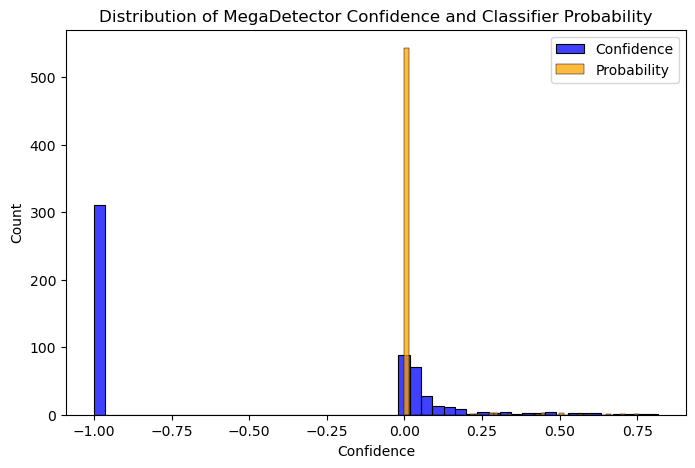

In [66]:
plt.figure(figsize=(8, 5))
sns.histplot(data=empties_df, x='Confidence',  bins=50, kde=False, label='Confidence', color='blue')
sns.histplot(data=empties_df, x='Probability',  bins=50, kde=False, label='Probability', color='orange')
plt.title('Distribution of MegaDetector Confidence and Classifier Probability')
plt.legend()
plt.show()

Now let's combine the empties and the independent dataframe, remove anything with less than 30 samples, and generate some overall metrics for reporting purposes.

In [67]:
filtered_encounter_df = cleaned_inf_df.groupby('Targets').filter(lambda x: len(x) >= 30)
filtered_encounter_df['Targets'].unique()

<StringArray>
[    'blackbird',           'cat',          'deer',        'ferret',          'goat',
          'hare',       'harrier',      'hedgehog',         'human',        'kereru',
          'kiwi',         'mouse', 'paradise_duck',           'pig',         'pipit',
        'possum',        'rabbit',           'rat',         'robin',     'silvereye',
         'stoat',        'thrush',        'tomtit',          'weka']
Length: 24, dtype: string

In [68]:
df = pd.concat([filtered_encounter_df.iloc[:, :8].copy(), empties_df.iloc[:, :8].copy()], ignore_index=True)

In [69]:
list(df['Targets'].unique())

['blackbird',
 'cat',
 'deer',
 'ferret',
 'goat',
 'hare',
 'harrier',
 'hedgehog',
 'human',
 'kereru',
 'kiwi',
 'mouse',
 'paradise_duck',
 'pig',
 'pipit',
 'possum',
 'rabbit',
 'rat',
 'robin',
 'silvereye',
 'stoat',
 'thrush',
 'tomtit',
 'weka',
 'empty']

['bellbird', 'blackbird', 'cat', 'deer', 'dog', 'dunnock', 'empty', 'fantail', 'ferret', 'finch', 'goat', 'hare', 'harrier', 'hedgehog', 'human', 'kea', 'kereru', 'kiwi', 'mouse', 'myna', 'paradise_duck', 'pig', 'pipit', 'possum', 'rabbit', 'rat', 'rifleman', 'robin', 'sealion', 'sheep', 'shore_plover', 'silvereye', 'sparrow', 'stoat', 'thrush', 'tomtit', 'weasel', 'weka']


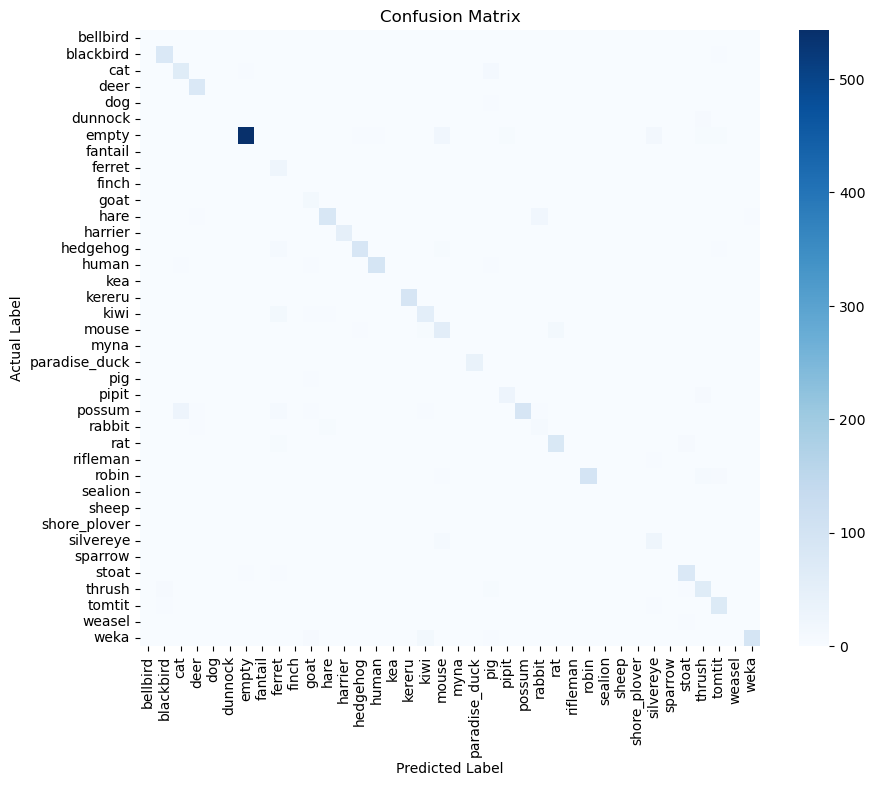

In [70]:
unique_labels_order = sorted(list(set(list(df['Targets'].unique()) + list(df['Encounter'].unique()))))
print(unique_labels_order)
conf_matrix = confusion_matrix(df['Encounter'], df['Targets'], labels=unique_labels_order)
plt.figure(figsize=(10, 8))
# Display the confusion matrix with label names
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=unique_labels_order, yticklabels=unique_labels_order)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [71]:
precision = precision_score(df['Targets'], df['Encounter'], average=None, labels=unique_labels_order, zero_division=1)
recall = recall_score( df['Targets'], df['Encounter'],  average=None, labels=unique_labels_order, zero_division=1)

targets = np.array( df['Targets'].to_list())
predictions = np.array(df['Encounter'].to_list())
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bal_accuracy = balanced_accuracy_score(targets, predictions)

animals_of_interest = ['possum','empty', 'cat', 'stoat', 'ferret', 'hedgehog', 'mouse', 'rabit', 
                       'hare', 'kiwi', 'kereru', 'goat','pig', 'pipit', 'deer', 'human', 'rat', 
                       'blackbird', 'robin', 'weka', 'harrier', 'paradise_duck']
target_counts = df['Targets'].value_counts()

print(Colour.S + f'The balanced accuracy score on this dataset is {bal_accuracy: .2f}' + Colour.E + "\n")
for label, prec, rec in zip(unique_labels_order, precision, recall):
    if label in animals_of_interest:
        count = target_counts.get(label, 0)  # Get the count for the current label
        print(f'{label}: Precision={prec:.2f}, Recall={rec:.2f}, Targets={count}')

The balanced accuracy score on this dataset is  0.74

blackbird: Precision=0.86, Recall=0.80, Targets=100
cat: Precision=0.81, Recall=0.64, Targets=100
deer: Precision=1.00, Recall=0.79, Targets=100
empty: Precision=0.89, Recall=0.97, Targets=561
ferret: Precision=1.00, Recall=0.38, Targets=66
goat: Precision=1.00, Recall=0.34, Targets=41
hare: Precision=0.73, Recall=0.86, Targets=100
harrier: Precision=1.00, Recall=1.00, Targets=49
hedgehog: Precision=0.80, Recall=0.89, Targets=100
human: Precision=0.87, Recall=0.95, Targets=100
kereru: Precision=1.00, Recall=1.00, Targets=93
kiwi: Precision=0.69, Recall=0.70, Targets=77
mouse: Precision=0.63, Recall=0.58, Targets=100
paradise_duck: Precision=1.00, Recall=1.00, Targets=39
pig: Precision=0.40, Recall=0.06, Targets=34
pipit: Precision=0.81, Recall=0.83, Targets=35
possum: Precision=0.62, Recall=0.92, Targets=100
rat: Precision=0.76, Recall=0.81, Targets=100
robin: Precision=0.81, Recall=0.96, Targets=100
stoat: Precision=0.84, Recall=0.